# **Optimasi Prediksi Pembatalan Reservasi Hotel untuk Mengurangi Kerugian dan Meningkatkan Efisiensi Operasional**

---

In [422]:
# Import library dasar
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing Data
from sklearn.preprocessing import (
    OneHotEncoder,
    RobustScaler,
    LabelEncoder
)
from category_encoders import OrdinalEncoder, BinaryEncoder

# Membagi dataset menjadi data latih dan uji
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold,
    RandomizedSearchCV
)

# Evaluasi metrik
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    fbeta_score,
    make_scorer,
)

# Pipeline untuk preprocessing dan model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Algoritma Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)

# Algoritma Boosting
import xgboost as xgb

# Penanganan dataset tidak seimbang
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline  # Pipeline dari imbalanced-learn

# Optimasi Hyperparameter
from scipy.stats import randint, uniform
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# BaseEstimator dan TransformerMixin
from sklearn.base import BaseEstimator, TransformerMixin  # Diperbaiki

# Menyimpan dan memuat model
import pickle

# Mengelola peringatan
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter('ignore')

# SHAP
import shap


## **1. Business Context and Problem Statement**

-------

#### **1.1. Background**

**Hotel São Sol**, sebuah hotel bintang empat di Portugal, sedang menghadapi tantangan besar dalam operasionalnya. Berdasarkan laporan keuangan terbaru, manajemen menemukan bahwa hotel mengalami kerugian yang signifikan akibat tingginya tingkat pembatalan booking. Dari data yang ada, sekitar **35% booking dibatalkan**, dan sebagian besar pembatalan terjadi mendekati tanggal check-in. Hal ini menyebabkan kamar yang kosong sulit dijual kembali, sehingga pendapatan yang seharusnya diterima dari kamar tersebut hilang begitu saja.

Untuk mengatasi masalah ini, manajemen awalnya mempertimbangkan strategi **overbooking**, yaitu menjual lebih banyak kamar daripada yang tersedia dengan asumsi bahwa sebagian tamu akan membatalkan. Namun, strategi ini memiliki risiko besar. Jika tamu yang diprediksi membatalkan ternyata tetap datang, hotel harus meminta mereka pindah ke akomodasi lain. Selain membutuhkan biaya kompensasi rata-rata **\$30 per tamu**, langkah ini juga dapat merusak reputasi hotel, terutama jika banyak tamu yang merasa kecewa dan memberikan ulasan negatif. Reputasi buruk ini bisa berdampak buruk terhadap bisnis hotel kedepannya.

Melihat situasi ini, manajemen Hotel São Sol akhirnya memutuskan untuk mengambil langkah strategis dengan mengembangkan sistem prediksi pembatalan booking menggunakan machine learning. Tim data analyst ditugaskan untuk membangun model prediksi yang dapat membantu hotel memahami pola pembatalan dengan lebih baik. Dengan prediksi ini, hotel diharapkan dapat mengelola booking dengan lebih efisien dan mengurangi kerugian akibat kamar kosong.

#### **1.2 Research Question**
**Bagaimana cara memprediksi pembatalan pelanggan secara akurat untuk meminimalkan kehilangan pendapatan dan mengoptimalkan okupansi kamar?**

Dengan menjawab pertanyaan ini, hotel dapat mengelola inventarisnya dengan lebih efektif, mengurangi risiko kehilangan pendapatan akibat pembatalan, dan memastikan kamar tersedia bagi pelanggan yang kemungkinan besar akan melanjutkan booking mereka

#### **1.3 Analytic Approach**

Dalam konteks bisnis hotel, baik **False Negatives (FN)** maupun **False Positives (FP)** memiliki dampak yang signifikan. Namun, biaya yang diakibatkan oleh **False Negatives** sering kali jauh lebih tinggi dibandingkan **False Positives**.<br>

**1.** `False Negatives (FN)`

- **Definisi**<br>
    **False Negatives** terjadi ketika model memprediksi bahwa sebuah booking tidak akan dibatalkan, tetapi kenyataannya tamu membatalkan.<br>

- **Dampak Bisnis**<br>
    Dalam industri perhotelan, dampak dari **False Negatives** sangat tinggi karena sifat inventaris kamar yang tidak dapat disimpan atau dijual di lain waktu. Ketika model gagal memprediksi pembatalan, hotel kehilangan kesempatan untuk menjual kembali kamar tersebut kepada tamu lain. Begitu malam berlalu tanpa tamu, pendapatan dari kamar tersebut hilang selamanya tanpa ada cara untuk memulihkannya.<br>

- **Poin Utama**<br>
    Di dunia perhotelan, setiap kamar yang kosong langsung berdampak pada pendapatan. Oleh karena itu, mengurangi **False Negatives** harus menjadi prioritas utama untuk memastikan hotel dapat menjual kembali kamar yang berisiko kosong ketika terjadi pembatalan.<br>

- **Biaya**<br>
    Untuk setiap **False Negative**, kerugian diperkirakan mencapai **$100** per kamar berdasarkan rata-rata harga kamar di Portugal yang dilansir dari website *budgetyourtrip* (https://www.budgetyourtrip.com/hotels/portugal-PT)<br>

**2.** `False Positives (FP)`

- **Definisi**<br>
    **False Positives** terjadi ketika model memprediksi bahwa sebuah booking akan dibatalkan, tetapi kenyataannya tamu tetap datang.<br>

- **Dampak Bisnis**<br>
    Dampak dari **False Positives** cenderung lebih kecil dibandingkan **False Negatives**, tetapi tetap memiliki konsekuensi yang signifikan. Ketika model salah memprediksi pembatalan, hotel mungkin melakukan overbooking, yakni menjual lebih banyak kamar daripada jumlah yang tersedia. Jika tamu yang diperkirakan membatalkan justru datang, hotel harus memindahkan mereka ke hotel lain, sering kali dengan biaya kompensasi tambahan. Ini tidak hanya merugikan secara finansial tetapi juga dapat menurunkan kepuasan pelanggan, terutama jika tamu merasa tidak dilayani dengan baik.<br>

- **Poin Utama**<br>
    Sementara dampak **False Positives** tidak seberat **False Negatives**, pengelolaan FP tetap penting untuk menghindari overbooking yang berlebihan. Pengalaman buruk tamu juga dapat berdampak pada reputasi hotel secara keseluruhan.<br>

- **Biaya**<br>
    Untuk setiap **False Positive**, biaya yang dikeluarkan untuk kompensasi rata-rata adalah **$30** per tamu.<br><br>

>**Menyeimbangkan False Negatives dan False Positives**

Walaupun **False Negatives** memberikan dampak yang lebih signifikan, **False Positives** juga tidak bisa diabaikan. Tujuan dari model prediksi ini adalah untuk meminimalkan **False Negatives** sebanyak mungkin tanpa meningkatkan **False Positives** secara berlebihan.

Untuk mengevaluasi model, digunakan metrik `F2 Score`. Metrik ini memberikan bobot lebih besar pada recall dibandingkan precision, karena kemampuan mendeteksi pembatalan (recall) adalah prioritas utama. Dengan pendekatan ini, hotel dapat mengurangi kerugian akibat pembatalan yang tidak terdeteksi, sambil menjaga keseimbangan agar overbooking tidak terlalu sering terjadi.

Pendekatan ini memungkinkan Hotel São Sol untuk mengoptimalkan pendapatan sekaligus menjaga pengalaman tamu tetap positif. Model yang efektif harus mampu menangani kedua jenis kesalahan ini dengan baik untuk memastikan operasional hotel berjalan lancar.



## **2. Data Description and Preparation**

-----

### **2.1 Load Data**

In [211]:
# Membaca dataset
df = pd.read_csv("data_hotel_booking_demand.csv")

# Menampilkan 5 baris pertama dari dataset
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


### **2.2 Attribute Information**

| Attribute | Data Type | Description |
| --- | --- | --- |
country | Object | Country of origin.
market_segment | Object | Market segment designation. 
previous_cancellations | Integer | Number of previous bookings that were cancelled by the customer prior to the current booking.
booking_changes | Integer | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation.
deposit_type | Object | Indication on if the customer made a deposit to guarantee the booking. 
days_in_waiting_list | Integer | Number of days the booking was in the waiting list before it was confirmed to the customer.
customer_type | Object | Type of booking.
reserved_room_type | Object | Code of room type reserved. Code is presented instead of designation for anonymity reasons.
required_car_parking_space | Integer | Number of car parking spaces required by the customer.
total_of_special_request | Integer | Number of special requests made by the customer (e.g. twin bed or high floor).
is_canceled | Integer | Value indicating if the booking was canceled (1) or not (0).

### **2.3 Copy Data**

In [212]:
# Membuat salinan dari dataset df
df2 = df.copy()
df2.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


## **3. Exploration Data Analysis**

-----

### **3.1 Dataset Overview** 

In [213]:
# Menampilkan bentuk dataset (jumlah baris dan kolom)
rows, columns = df2.shape
print(f"The dataset has {rows} rows and {columns} columns.")

The dataset has 83573 rows and 11 columns.


In [214]:
#  Menampilkan informasi umum mengenai dataset
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [215]:
categorical_cols = list(df.select_dtypes(['object','category']).columns)
numerical_cols = list(set(df.select_dtypes(['number']).columns) - set(categorical_cols) - {'is_canceled'})

### **3.2 Descriptive Statistics** 

In [216]:
# Menampilkan statistik deskriptif untuk kolom numerik
display(df2.describe().T,
        df2.describe(include= object).T)

,count,mean,std,min,25%,50%,75%,max
previous_cancellations,83573.0,0.086798,0.841011,0.0,0.0,0.0,0.0,26.0
booking_changes,83573.0,0.220897,0.648635,0.0,0.0,0.0,0.0,21.0
days_in_waiting_list,83573.0,2.330561,17.673051,0.0,0.0,0.0,0.0,391.0
required_car_parking_spaces,83573.0,0.062999,0.246919,0.0,0.0,0.0,0.0,8.0
total_of_special_requests,83573.0,0.573211,0.795163,0.0,0.0,0.0,1.0,5.0
is_canceled,83573.0,0.368277,0.482340,0.0,0.0,0.0,1.0,1.0


,count,unique,top,freq
country,83222,162,PRT,34097
market_segment,83573,8,Online TA,39460
deposit_type,83573,3,No Deposit,73352
customer_type,83573,4,Transient,62732
reserved_room_type,83573,10,A,60041


### **3.3 Unique Values** 

In [217]:
# Menampilkan nilai unik per kolom
pd.set_option('display.max_colwidth', None)
listItem = []
for col in df2.columns :
 
    listItem.append( [col, df2[col].nunique(), df2[col].unique()   ])

unique_values = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
unique_values

,Column Name,Number of Unique,Unique Sample
0,country,162,"[IRL, FRA, PRT, NLD, ESP, UMI, CN, LUX, BRA, BEL, JPN, DEU, ITA, CHE, GBR, AGO, SRB, COL, CHN, SWE, AUT, CIV, CZE, POL, USA, SGP, RUS, ROU, DNK, IND, MAR, PHL, ARG, ISL, ZAF, LBN, MOZ, TUR, BGD, MEX, CAF, NOR, FIN, UKR, EGY, ISR, nan, KOR, AZE, HUN, AUS, EST, CHL, SVN, PRY, ABW, ALB, LTU, ARE, HRV, SAU, NZL, LVA, ATA, KAZ, DZA, TWN, CRI, BIH, BGR, IRQ, OMN, VEN, IDN, GEO, MLT, IRN, BLR, URY, LBY, TUN, BEN, MYS, MWI, GRC, CYP, CPV, HKG, PRI, MKD, MUS, IMN, PAN, NGA, GLP, KHM, PER, QAT, SEN, MAC, ...]"
1,market_segment,8,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation, Undefined]"
2,previous_cancellations,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19, 5, 21]"
3,booking_changes,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12, 14, 21, 16, 20, 15]"
4,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31, 122, 34, 57, 259, 50, 17, 32, 43, 75, 69, 44, 22, 113, 58, 38, 65, 48, 236, 176, 25, 108, 91, 19, 160, 68, 28, 63, 35, 42, 59, 24, 8, 183, 187, 21, 111, 56, 98, 101, 15, 16, 47, 93, 45, 14, 70, 10, 49, 178, 99, 60, 40, 85, 223, 6, 33, 391, 20, 1, 41, 147, 55, 80, 379, 150, 61, 330, 174, 107, 96, 18, 62, 13, 30, 120, 27, 207, 71, 2, 76, 125, 5, 9, 224, 53, 83, 84, 12, ...]"
6,customer_type,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,10,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,6,"[0, 2, 1, 3, 4, 5]"


### **3.4 Missing Values** 

In [218]:
# missing values

# Mengecek df kosong
df_missing_value = df2.isnull().sum().reset_index().rename(columns={'index':'column', 0:'Missing Value'})
df_missing_value['Percentage Total Missing Value (%)'] = (df_missing_value['Missing Value'] / len(df2) * 100).round(2)

# Menambahkan tanda persen (%) ke kolom 'Percentage Total Missing Value (%)'
df_missing_value['Percentage Total Missing Value (%)'] = df_missing_value['Percentage Total Missing Value (%)'].apply(lambda x: f'{x:.2f}%')

# Mengubah index agar dimulai dari 1
df_missing_value.index = range(1, len(df_missing_value) + 1)

df_missing_value

,column,Missing Value,Percentage Total Missing Value (%)
1,country,351,0.42%
2,market_segment,0,0.00%
3,previous_cancellations,0,0.00%
4,booking_changes,0,0.00%
5,deposit_type,0,0.00%
6,days_in_waiting_list,0,0.00%
7,customer_type,0,0.00%
8,reserved_room_type,0,0.00%
9,required_car_parking_spaces,0,0.00%
10,total_of_special_requests,0,0.00%


> Dataset ini memiliki **351 missing values** pada kolom `country`, yang setara dengan **0,42% dari total data**.

>Untuk memastikan konsistensi dataset dan menghindari pengaruh negatif pada kinerja model machine learning, baris dengan missing values pada kolom tersebut akan dihapus. Langkah ini bertujuan agar model dapat belajar secara optimal tanpa terdistorsi oleh data yang tidak lengkap.

In [219]:
# menghapus data yg memiliki missing values
df2.dropna(inplace=True)

In [220]:
# Memeriksa jumlah 'missing value' setelah penghapusan
df2.isna().sum()

country                        0
market_segment                 0
previous_cancellations         0
booking_changes                0
deposit_type                   0
days_in_waiting_list           0
customer_type                  0
reserved_room_type             0
required_car_parking_spaces    0
total_of_special_requests      0
is_canceled                    0
dtype: int64

### **3.5 Duplicated Data** 

In [221]:
# Cek apakah ada baris duplikat
duplikat = df2.duplicated()

# Menampilkan jumlah data duplikat
print(f"Jumlah data duplikat ada {duplikat.sum()}")

Jumlah data duplikat ada 73138


> Dataset ini mengandung **73.138 data duplikat**. 

>Karena data ini akan digunakan untuk machine learning, duplikasi harus dihapus untuk mencegah model belajar secara berlebihan dari data yang berulang, sehingga hasilnya lebih akurat dan tidak bias.

In [222]:
# menghapus data duplikat
df2.drop_duplicates(inplace=True)

In [223]:
# Memeriksa jumlah data duplikat setelah penghapusan
df2.duplicated().sum()

0

### **3.6 Undefined Value in 'market_segment'** 

In [224]:
# Menghitung jumlah kategori di kolom market_segment
display(df2['market_segment'].value_counts())

market_segment
Online TA        4924
Direct           2079
Offline TA/TO    1469
Groups            845
Corporate         505
Complementary     180
Aviation           81
Undefined           1
Name: count, dtype: int64

> Kategori `Undefined` pada kolom `market_segment` akan dihapus karena dianggap sebagai **data kosong (NaN/Null)**. 

In [225]:
# Mengganti nilai 'Undefined' dengan None
df2['market_segment'] = df2['market_segment'].replace('Undefined', None)

In [226]:
# Menghapus baris dengan nilai kosong di kolom market_segment
df2.dropna(subset=['market_segment'], inplace=True)

In [227]:
# Menghitung kembali jumlah kategori setelah penghapusan
display(df2['market_segment'].value_counts())

market_segment
Online TA        4924
Direct           2079
Offline TA/TO    1469
Groups            845
Corporate         505
Complementary     180
Aviation           81
Name: count, dtype: int64

### **3.7 Data Correlation** 

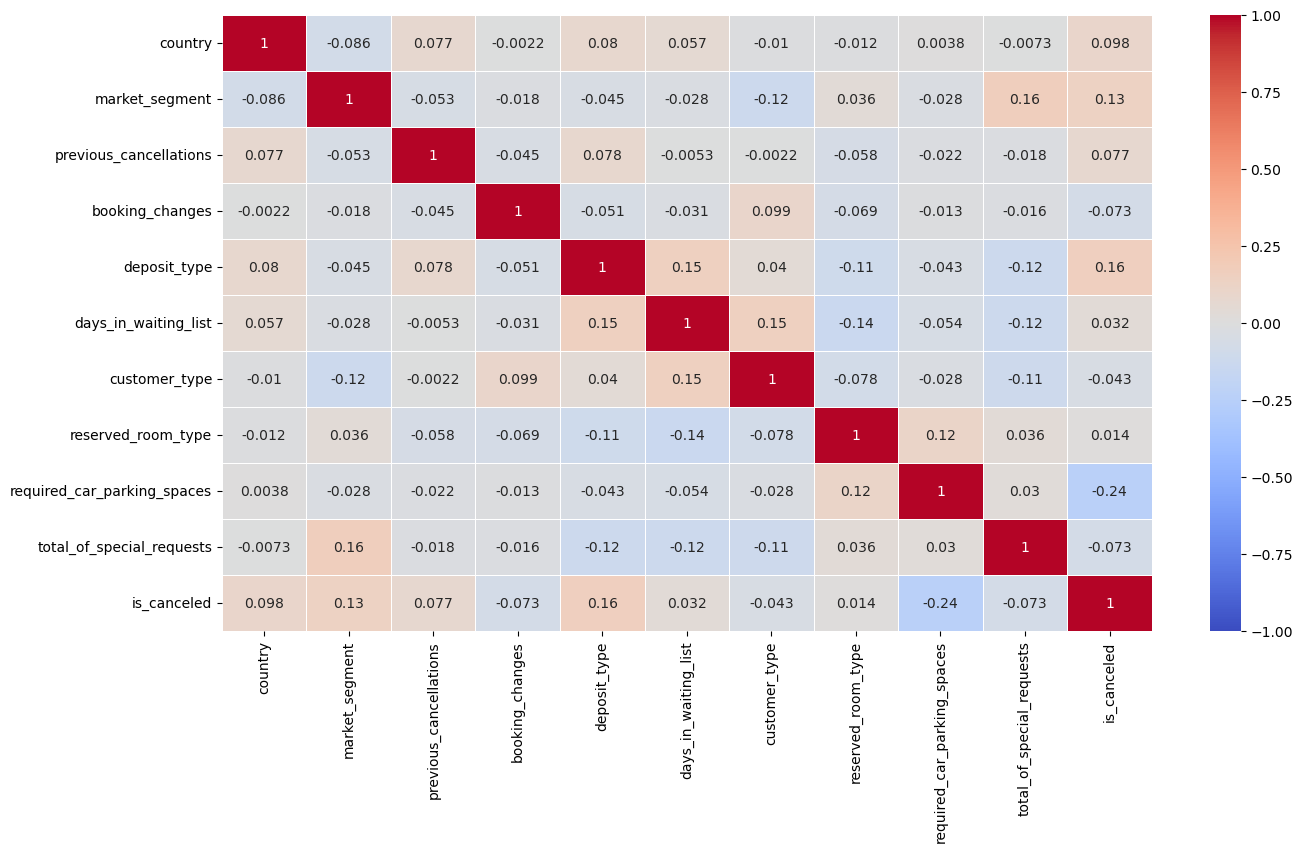

In [228]:
# Melakukan label encoding untuk kolom non-numerik
label_encoder = LabelEncoder()
df2_encoded = df2.copy()

# Apply label encoding hanya untuk kolom yang bukan numerik
for col in df2_encoded.select_dtypes(exclude=[np.number]).columns:
    df2_encoded[col] = label_encoder.fit_transform(df2_encoded[col])

# Membuat heatmap korelasi untuk seluruh kolom, termasuk yang sudah di-encode
plt.figure(figsize=(15, 8))
sns.heatmap(df2_encoded.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm", linewidths=0.5)
plt.show()



>Berdasarkan heatmap di atas, korelasi tertinggi antara `is_canceled` dan fitur lain adalah dengan `total_of_special_requests` sebesar **-0.24**. 

>Korelasi negatif ini menunjukkan bahwa semakin banyak permintaan khusus, kemungkinan pembatalan cenderung lebih rendah.

### **3.8 Imbalance Data** 

In [229]:
# Melihat jumlah distribusi nilai pada kolom is_canceled
df2['is_canceled'].value_counts()

is_canceled
0    7688
1    2395
Name: count, dtype: int64

Text(0.5, 0, "'is_canceled' Status")

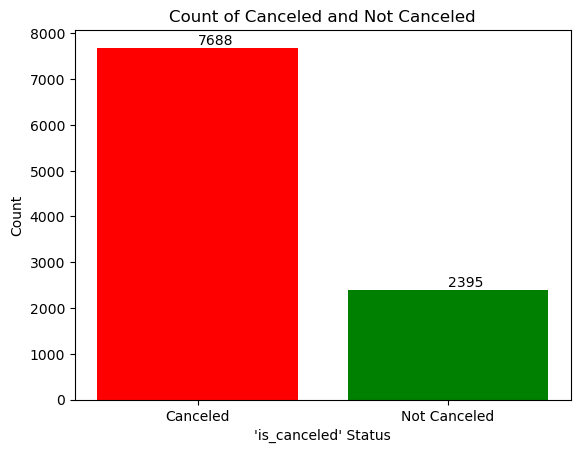

In [230]:
# Memperbarui kategori dan jumlah
categories = ['Canceled', 'Not Canceled']
counts = df2['is_canceled'].value_counts()

# Membuat diagram batang yang diperbarui
fig, ax = plt.subplots()
bars = ax.bar(categories, counts, color=['red', 'green'])

# Menambahkan jumlah di atas batang
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom')  # va: vertical alignment

# Menambahkan judul dan label
ax.set_title('Count of Canceled and Not Canceled')
ax.set_ylabel('Count')
ax.set_xlabel("'is_canceled' Status")

>Dataset menunjukkan **ketidakseimbangan**, dengan jumlah data `Canceled` **(7.688)** jauh lebih banyak dibandingkan `Not Canceled` **(2.395)**. Ketidakseimbangan ini dapat menyebabkan bias pada model, sehingga perlu penanganan seperti resampling.

### **3.9 Data Distribution and Visualization** 

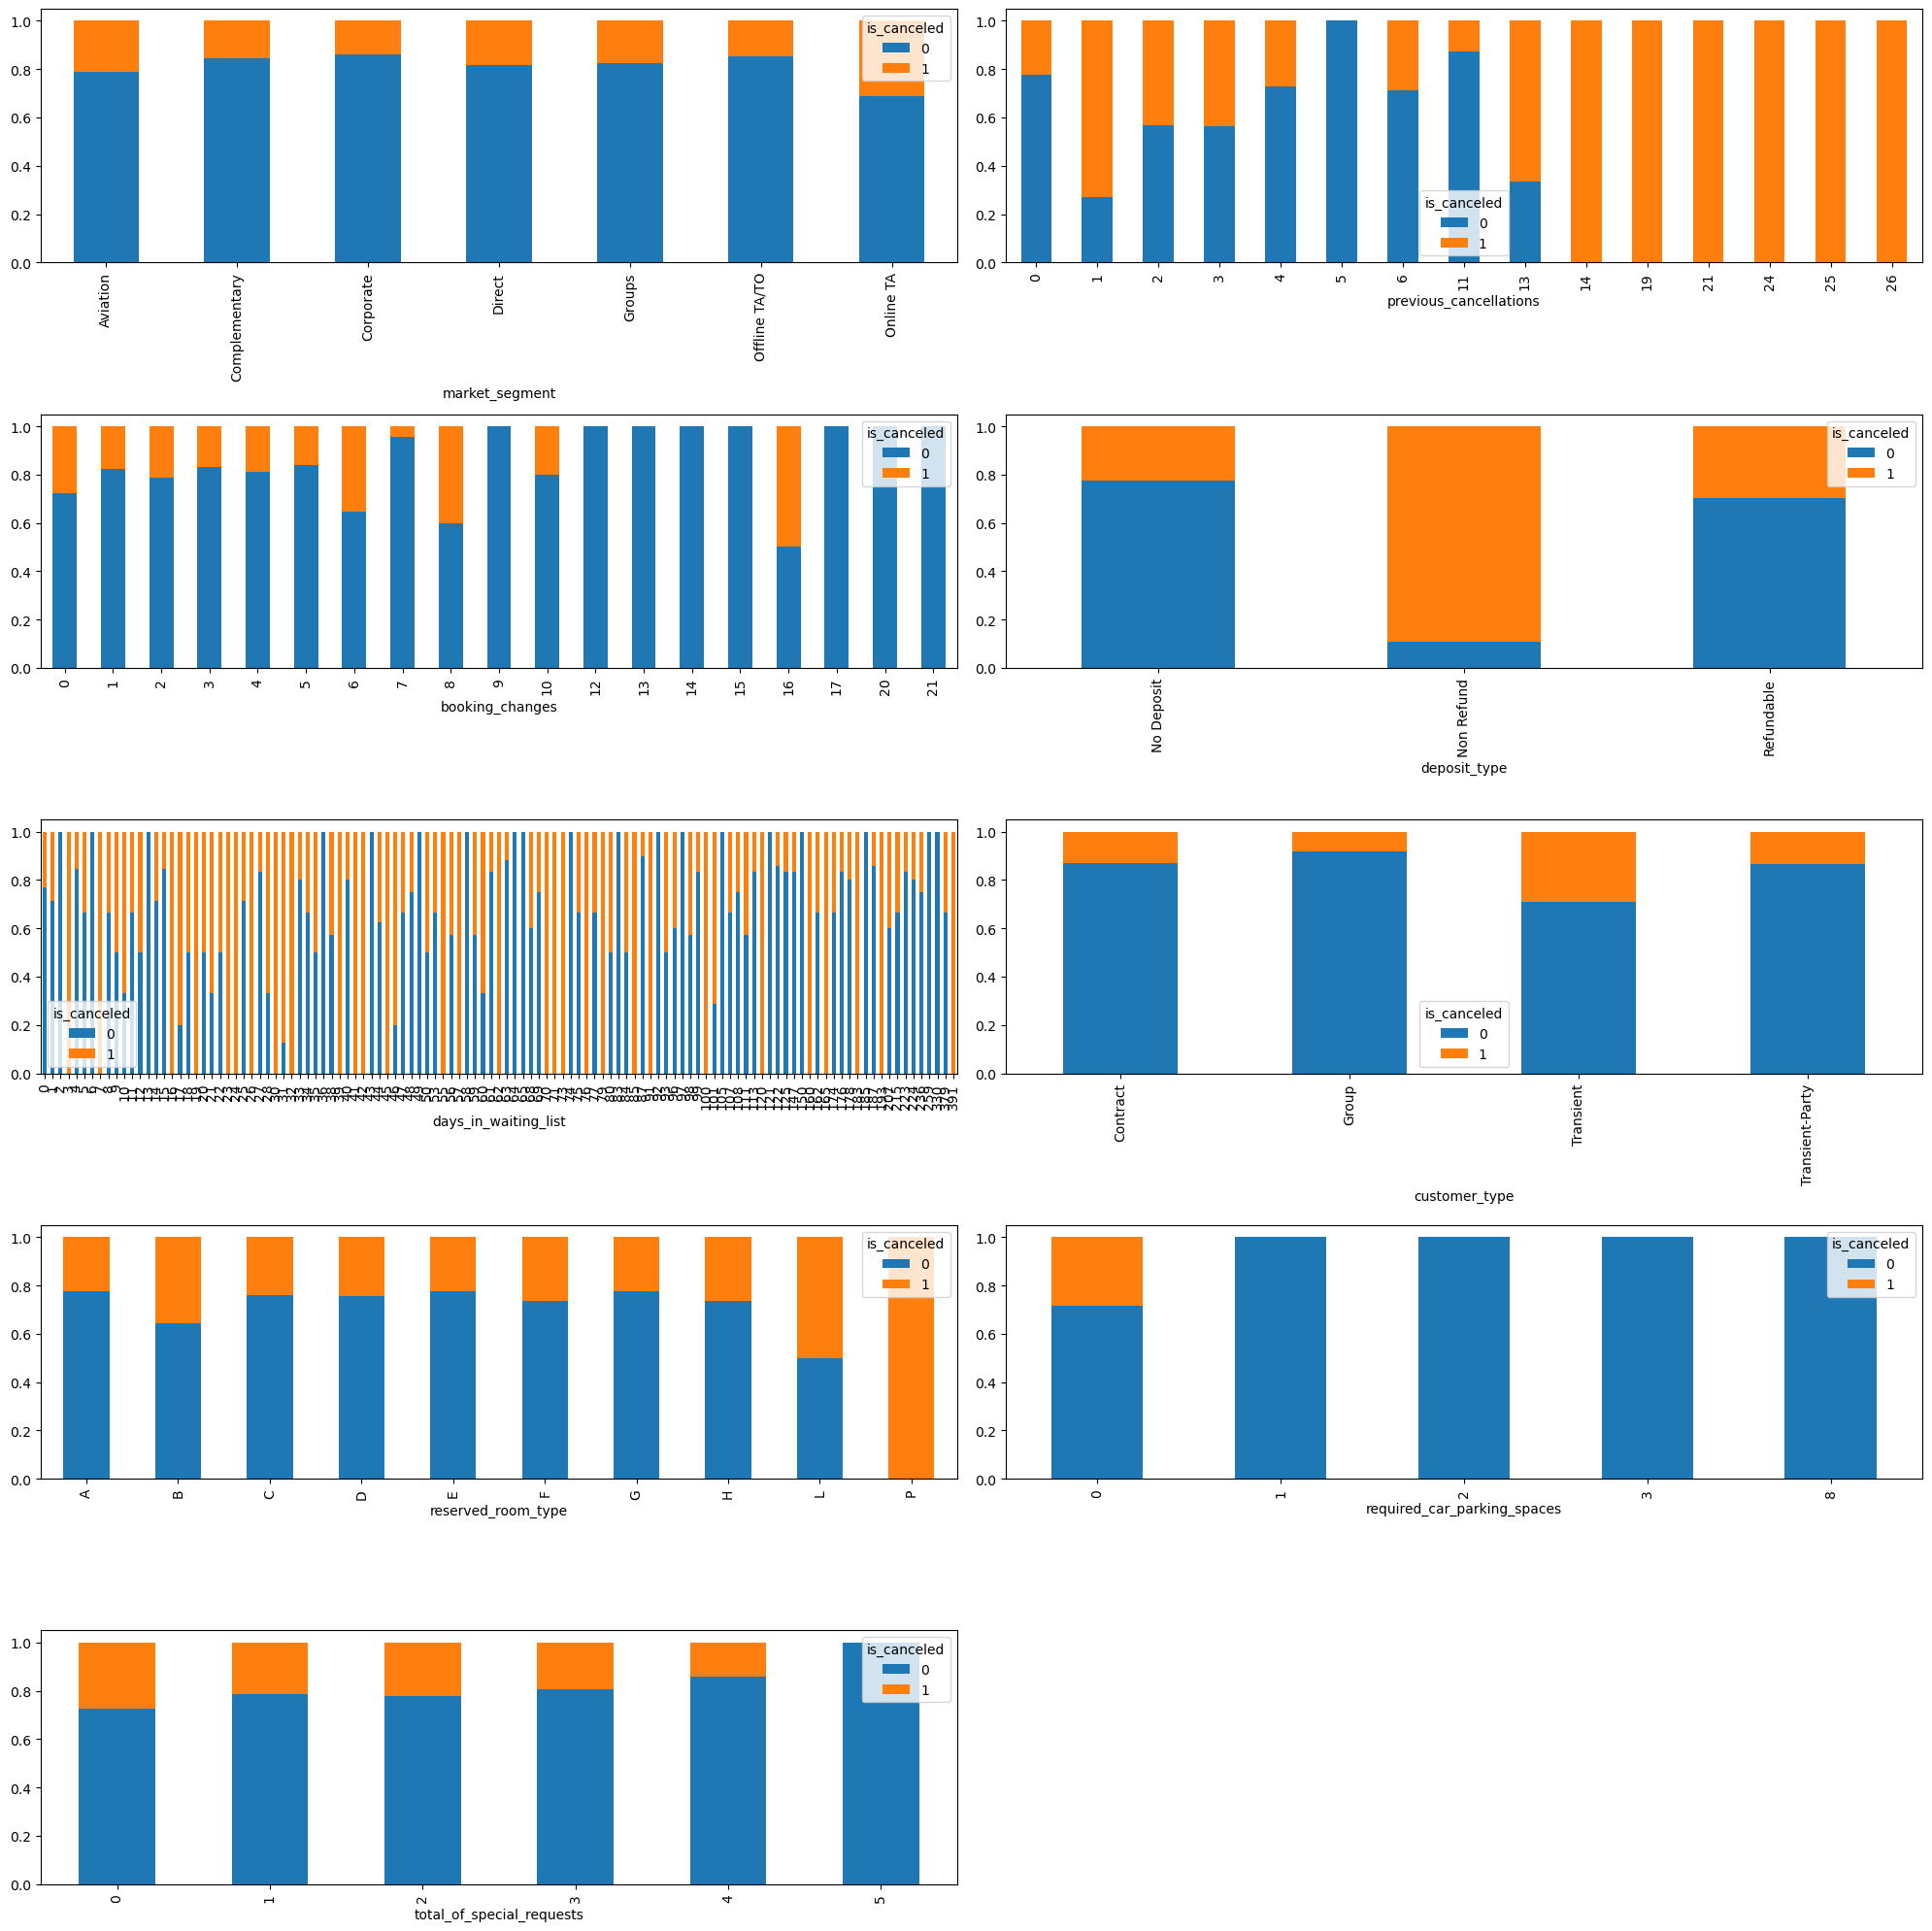

In [231]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df2.drop(columns=['is_canceled','country']).columns:
    count +=1
    ax= plt.subplot(5,2,count)
    pd.crosstab(df2[i],df2['is_canceled'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

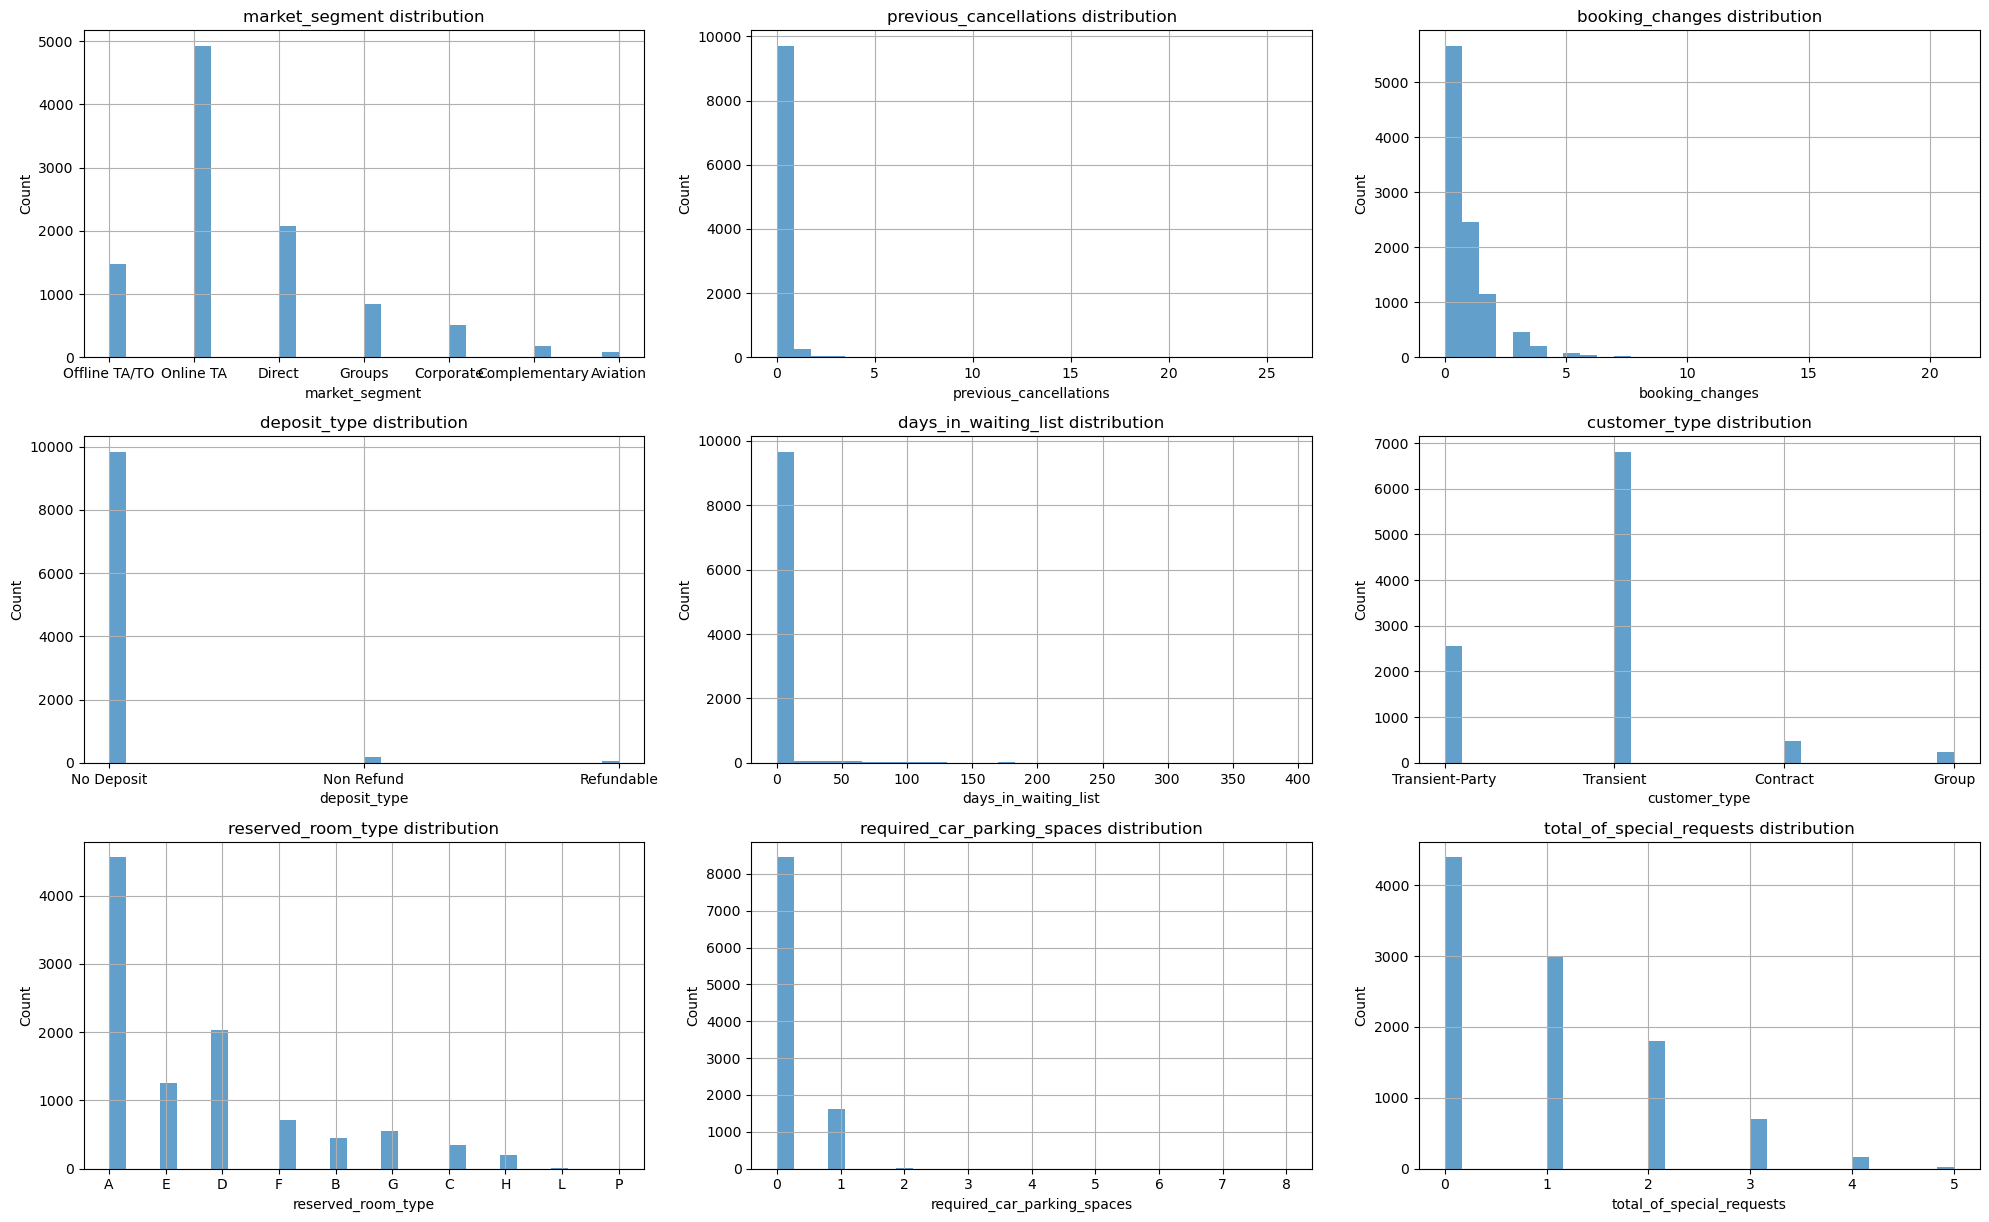

In [232]:
# Membuat visualisasi distribusi setiap fitur
import matplotlib.pyplot as plt

count = 0
fig = plt.figure(figsize=(20, 20))  # Ukuran figure yang lebih besar untuk menampung semua plot

for i in df2.drop(columns=['is_canceled', 'country']).columns:
    count += 1
    ax = plt.subplot(5, 3, count)  # Ubah grid jika ada lebih dari 10 fitur
    df2[i].hist(bins=30, alpha=0.7, ax=ax)  # Menggunakan histogram untuk fitur numerik
    ax.set_title(f"{i} distribution")  # Menambahkan judul untuk setiap plot
    ax.set_xlabel(i)  # Menambahkan label x
    ax.set_ylabel("Count")  # Menambahkan label y

fig.tight_layout()  # Agar plot tidak saling bertumpuk
plt.show()

> Tidak ada kolom numerik yang memiliki distribusi normal. Jika diperlukan, dapat digunakan `Robust Scaler` untuk menangani data tersebut.

### **3.10 Outliers** 

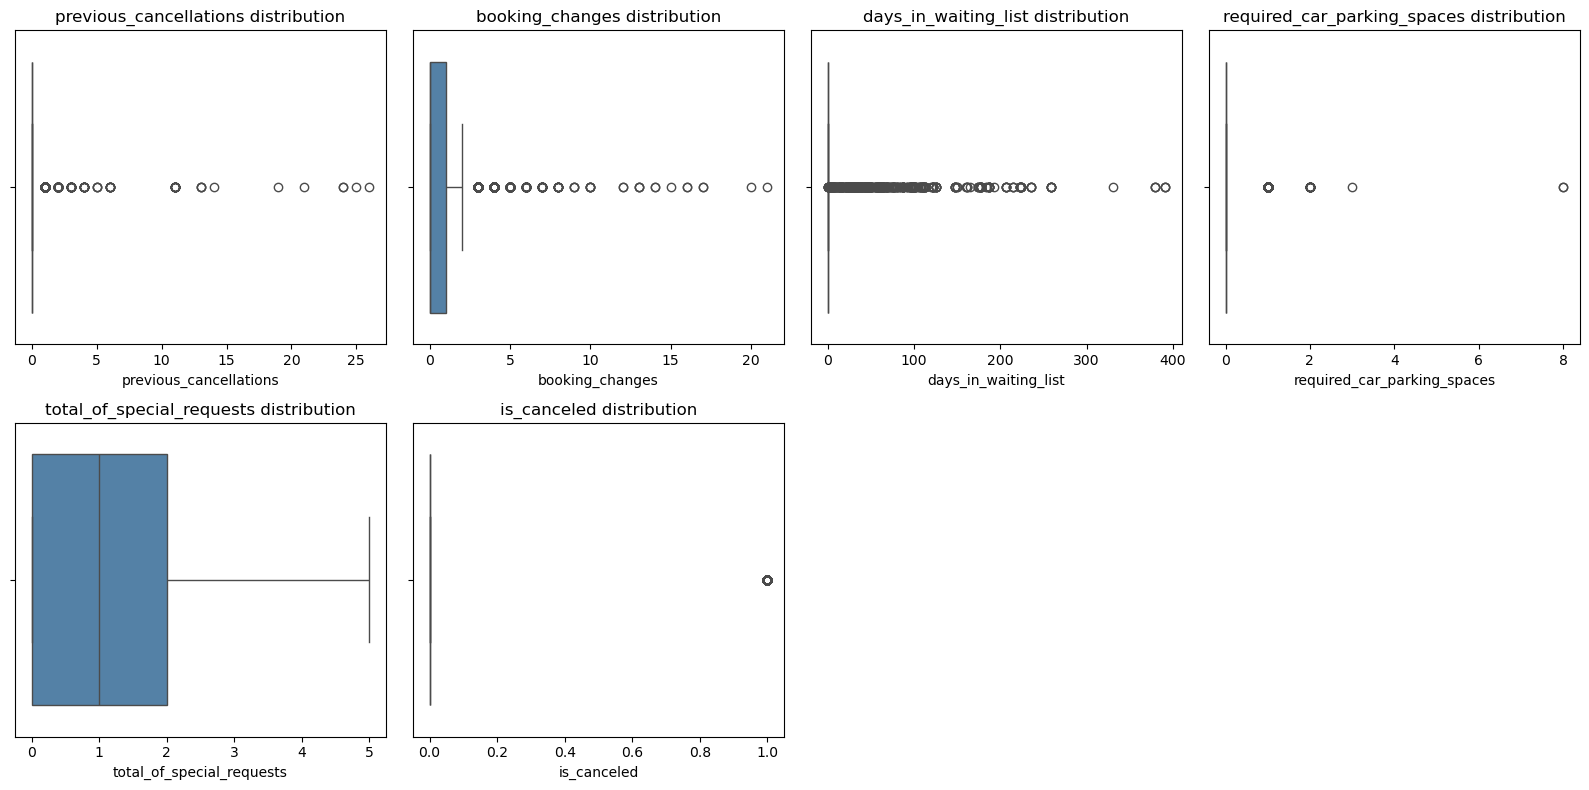

In [233]:
# Menghitung jumlah subplot berdasarkan jumlah kolom numerik
n_cols = 4  # Jumlah kolom dalam grid
n_rows = int(np.ceil(len(df2.select_dtypes(include=np.number).columns) / n_cols))  # Jumlah baris

# Membuat subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 4))

# Meratakan array axes agar mudah diakses dalam loop
axes = axes.flatten()

# Looping untuk setiap kolom numerik dan membuat boxplot
for i, column in enumerate(df2.select_dtypes(include=np.number).columns):
    sns.boxplot(x=df2[column], ax=axes[i], color="steelblue")  # Membuat boxplot
    axes[i].set_title(f'{column} distribution')  # Menambahkan judul
    axes[i].set_xlabel(column)  # Menambahkan label sumbu x

# Menghapus subplot kosong jika jumlah kolom tidak sesuai dengan grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Menyesuaikan layout agar tidak bertumpuk
plt.tight_layout()

# Menampilkan plot
plt.show()

>Outliers tidak dihapus karena dianggap relevan dan mencerminkan data nyata. 

## **4.Model 1**

-----

### **4.1 Pre-processing for Modeling 1**

#### **4.1.1 Define X and y** 

In [234]:
# Memisahkan fitur (X) dan target (y)
X = df2.drop(columns=['is_canceled'])  
y = df2['is_canceled']  

#### **4.1.2 Data Splitting** 

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify= y,
                                                    test_size=0.2, 
                                                    random_state=0)

**Menggunakan **`stratify=y`** memastikan distribusi variabel target tetap sama di data pelatihan (training) dan pengujian (testing). Berikut alasan mengapa stratifikasi penting dalam **`train_test_split`**:**

1. **Meningkatkan Generalisasi**:  

Dengan distribusi kelas yang sama, model lebih mampu mengenali pola data dan menghasilkan prediksi yang akurat pada data baru. Ini karena model dilatih dengan data yang mencerminkan kondisi serupa yang akan dihadapi saat evaluasi.

2. **Konsistensi Hasil**:  

Jika menggunakan cross-validation, stratifikasi memastikan setiap fold memiliki distribusi kelas yang serupa, sehingga hasil evaluasi menjadi lebih stabil dan konsisten.

---

**Rasio pembagian 80:20 untuk data pelatihan dan pengujian dipilih karena:**

1. **Keseimbangan Pelatihan dan Pengujian**:  
   Rasio ini memberikan cukup data untuk melatih model secara optimal, sekaligus menyisakan data yang cukup untuk mengevaluasi performa. Jika data pengujian terlalu kecil, hasil evaluasi bisa menjadi tidak akurat dan kurang representatif.

2. **Standar yang Umum Digunakan**:  
   Rasio 80:20 adalah standar yang sering digunakan dalam machine learning. Rasio ini telah terbukti efektif di berbagai jenis dataset dan menjadi pilihan yang aman dalam banyak skenario.

#### **4.1.3 Encoding and Scaling** 



#### **Encoding**

Proses encoding dilakukan untuk mengubah data kategori menjadi numerik agar dapat digunakan dalam machine learning. Berikut pendekatan yang digunakan:

1. `Country`:  
   Menggunakan `Binary Encoding` karena jumlah kategori unik (nunique) mencapai 162.  
   Menggunakan One-Hot Encoding akan menghasilkan terlalu banyak kolom, sehingga Binary Encoding lebih efisien.

<br>

2. `Market Segment`:  
   Menggunakan `Binary Encoding` karena jumlah kategori unik (nunique) adalah 8, sehingga Binary Encoding lebih tepat untuk menghindari jumlah kolom yang berlebihan.

<br>

3. `Deposit Type`:  
   Menggunakan `One-Hot Encoding` karena jumlah kategori unik (nunique) hanya 3, sehingga pendekatan ini efisien.

<br>

4. `Customer Type`:  
   Menggunakan `One-Hot Encoding` karena jumlah kategori unik (nunique) hanya 4, sehingga cocok untuk pendekatan ini.

<br>

5. `Reserved Room Type`:  
   Menggunakan `Ordinal Encoding` karena nilai-nilainya memiliki urutan atau hierarki tertentu.


---

#### **Scaling**

Proses scaling dilakukan untuk menormalkan skala fitur numerik dan meminimalkan pengaruh outliers. Berikut fitur yang diskalakan:

1. `Previous Cancellations` → Menggunakan `Robust Scaler`.

2. `Booking Changes` → Menggunakan `Robust Scaler`.

3. `Days in Waiting List` → Menggunakan `Robust Scaler`.

4. `Required Car Parking Space` → Menggunakan `Robust Scaler`.

5. `Total of Special Requests` → Menggunakan `Robust Scaler`.


<br>


>*Notes*:
Robust Scaler digunakan karena tidak ada kolom numerik yang memiliki distribusi normal. Robust Scaler menggunakan median dan interquartile range (IQR), sehingga lebih tahan terhadap outliers.

In [236]:
# Mapping untuk Ordinal Encoding
# Menentukan urutan/hierarki untuk kolom 'reserved_room_type'
ordinal_encoder = [{'col': 'reserved_room_type',
                    'mapping': {'A': 1, 'E': 2, 'D': 3, 'F': 4, 'B': 5, 'G': 6, 'C': 7, 'H': 8, 'P': 9}}]

In [237]:
# Membuat ColumnTransformer untuk preprocessing
transformer = ColumnTransformer([
    # One-Hot Encoding untuk kolom dengan kategori sedikit
    ('one hot encoding', OneHotEncoder(drop='first'), ['deposit_type', 'customer_type']),
    
    # Binary Encoding untuk kolom dengan kategori banyak
    ('binary encoding', BinaryEncoder(), ['country', 'market_segment']),
    
    # Ordinal Encoding untuk kolom dengan nilai ordinal
    ('ordinal_encoding', OrdinalEncoder(mapping=ordinal_encoder, cols=['reserved_room_type']), ['reserved_room_type']),
    
    # Robust Scaler untuk normalisasi fitur numerik
    ('robust scaler', RobustScaler(), [
        'previous_cancellations', 
        'booking_changes', 
        'days_in_waiting_list', 
        'required_car_parking_spaces', 
        'total_of_special_requests'
    ]),
], remainder='passthrough')  

# Menampilkan struktur transformer
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('one hot encoding',
                                 OneHotEncoder(drop='first'),
                                 ['deposit_type', 'customer_type']),
                                ('binary encoding', BinaryEncoder(),
                                 ['country', 'market_segment']),
                                ('ordinal_encoding',
                                 OrdinalEncoder(cols=['reserved_room_type'],
                                                mapping=[{'col': 'reserved_room_type',
                                                          'data_type': dtype('O'),
                                                          'mapping': A    1
E    2
D    3
F    4
B    5
G    6
C    7
H    8
P    9
dtype: int64}]),
                                 ['reserved_room_type']),
                                ('robust scaler', RobustScaler(),
                                 ['previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests'])])

### **4.2. Modeling**

-----

#### **4.2.1 Model Selection** 

In [238]:
# Mendefinisikan model individu
tree = DecisionTreeClassifier(random_state=0)
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()



In [239]:

# Mendefinisikan model ensemble
forest = RandomForestClassifier(random_state=0)
adaboost = AdaBoostClassifier(random_state=0)
gradient = GradientBoostingClassifier(random_state=0)
xgboost = xgb.XGBClassifier(random_state=0)

#### **4.2.2 Scoring Metric Selection** 

In [240]:
# Membuat metrik F-beta score dengan beta=2 untuk memberikan bobot lebih pada recall
scoring_f2 = make_scorer(fbeta_score, beta=2)


#### **4.2.3 Cross Validation** 

In [241]:
# Mendefinisikan daftar model yang akan dievaluasi
tree = DecisionTreeClassifier(random_state=0)
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
forest = RandomForestClassifier(random_state=0)
adaboost = AdaBoostClassifier(random_state=0)
gradient = GradientBoostingClassifier(random_state=0)
xgboost = xgb.XGBClassifier(random_state=0)

# Daftar model
list_model = [tree, forest, adaboost, gradient, xgboost, logreg, knn]

# Inisialisasi list untuk menyimpan hasil evaluasi
list_score = []
list_mean = []
list_std = []

# Iterasi untuk setiap model
for model in list_model:
    # Membuat Stratified K-Fold untuk membagi data menjadi 5 fold secara stratifikasi
    cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    # Membuat pipeline: gabungan preprocessing dan model
    pipe_prep_model = Pipeline([
        ('preprocessing', transformer),  
        ('model', model)  
    ])
    
    # Melakukan cross-validation
    cv_score = cross_val_score(
        estimator=pipe_prep_model,  
        scoring=scoring_f2,         
        X=X_train,                  
        y=y_train,                  
        cv=cv5,                     
        n_jobs=-1                  
    )
    
    # Menyimpan hasil skor ke dalam list
    list_score.append(cv_score.round(2))  
    list_mean.append(cv_score.mean())     
    list_std.append(cv_score.std())       

/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

**Apa itu `StratifiedKFold?`**
<br>

- `StratifiedKFold` adalah teknik cross-validation yang memastikan setiap bagian (fold) data memiliki proporsi kelas target yang sama seperti di dataset asli.

- Teknik ini sangat penting untuk dataset yang tidak seimbang agar evaluasi model tetap adil dan tidak bias terhadap kelas tertentu.

---

**Apa itu `n_splits=5`?**
<br>

- Parameter `n_splits=5` mengatur jumlah bagian (fold) data menjadi 5 subset.
<br>

- Proses cross-validation akan berjalan sebanyak 5 iterasi. <br><br>
- Pada setiap iterasi :<br><br>
        4 fold digunakan untuk melatih model (training).<br>
        1 fold digunakan untuk menguji model (validation).
<br><br>
- Setiap fold akan bergantian menjadi data validasi satu kali, sehingga semua data digunakan baik untuk pelatihan maupun pengujian.

In [242]:
# Membuat DataFrame untuk menyimpan hasil evaluasi model
df2_score = pd.DataFrame({
    'model': ['tree', 'forest', 'adaboost', 'gradient', 'xgboost', 'logreg', 'knn'],
    'f2 score': list_score,
    'f2 mean': list_mean,
    'f2 std': list_std
})

# Mengurutkan DataFrame berdasarkan rata-rata skor F2 (f2 mean) secara descending
df2_score = df2_score.sort_values('f2 mean', ascending=False)
df2_score

,model,f2 score,f2 mean,f2 std
4,xgboost,"[0.37, 0.39, 0.38, 0.43, 0.38]",0.389529,0.019389
2,adaboost,"[0.33, 0.31, 0.31, 0.35, 0.34]",0.329437,0.016050
6,knn,"[0.33, 0.32, 0.32, 0.32, 0.36]",0.328174,0.015521
1,forest,"[0.28, 0.3, 0.29, 0.33, 0.32]",0.303104,0.018224
0,tree,"[0.28, 0.32, 0.29, 0.31, 0.32]",0.302781,0.016811
3,gradient,"[0.26, 0.27, 0.28, 0.34, 0.32]",0.293445,0.030547
5,logreg,"[0.29, 0.28, 0.31, 0.29, 0.28]",0.290471,0.012910


Model terbaik adalah `XGBoost`.

**Alasannya:**

**1. Kemampuan Mengurangi Overfitting**<br>
`XGBoost` dilengkapi dengan regularisasi L1 dan L2 yang membantu mengontrol kompleksitas model. Hal ini sangat penting untuk mengurangi risiko overfitting, terutama pada dataset dengan banyak fitur atau noise.

**2. Kemampuan Menangkap Pola Non-Linear**<br>
Berbasis pada pohon keputusan, `XGBoost` mampu menangkap hubungan yang kompleks atau non-linear dalam data. Hal ini memberikan keunggulan dibandingkan model sederhana seperti Logistic Regression yang hanya dapat menangkap hubungan linear.

**3. Mekanisme Boosting yang Efisien**<br>
Proses boosting pada `XGBoost` bekerja secara iteratif, di mana setiap pohon baru berfokus untuk memperbaiki kesalahan prediksi dari pohon sebelumnya. Pendekatan ini menghasilkan model yang lebih akurat dan efektif.

#### **4.2.4 Handling Imbalance Data**

In [243]:
# Metode Resampling
smote = SMOTE(random_state=0)
ros = RandomOverSampler(random_state=0)
rus = RandomUnderSampler(random_state=0)
nm = NearMiss(sampling_strategy='majority')

In [244]:
# Model yang terpilih
xgboost = xgb.XGBClassifier(random_state=0)

# Daftar resampling yang akan dicoba
list_resampler = [None, smote, ros, rus, nm]  

# Inisialisasi list untuk menyimpan hasil evaluasi
score = []
list_mean = []
list_std = []
list_recall_test = []

for resampler in list_resampler:
    # Membuat Stratified K-Fold untuk cross-validation
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Membuat pipeline: gabungan preprocessing, resampling, dan model
    model_pipe = Pipeline([
        ('transform', transformer), 
        ('balancing', resampler),    
        ('model', xgboost)                
    ])

    # Melakukan cross-validation
    model_cv = cross_val_score(
        model_pipe,
        X_train,
        y_train,
        cv=skfold,
        scoring=scoring_f2,  
        error_score='raise'  
    )

    # Menyimpan hasil evaluasi ke dalam list
    score.append(model_cv)
    list_mean.append(model_cv.mean())  
    list_std.append(model_cv.std())    


In [245]:
# Membuat DataFrame untuk menyimpan hasil evaluasi model dengan resampler
df_score_resampler = pd.DataFrame({
    'resampler': list_resampler,
    'mean': list_mean,
    'std': list_std,
})

# Mengurutkan DataFrame berdasarkan rata-rata skor F2 secara descending
df_score_resampler.sort_values('mean', ascending=False)

,resampler,mean,std
3,RandomUnderSampler(random_state=0),0.695374,0.010301
2,RandomOverSampler(random_state=0),0.680966,0.010235
1,SMOTE(random_state=0),0.461041,0.011377
4,NearMiss(sampling_strategy='majority'),0.446687,0.018199
0,None,0.389529,0.019389


 **Cara Kerja `Random Under Sampling (RUS)`**<BR><BR>
`Random Under Sampling` bekerja dengan mengurangi jumlah sampel dari kelas mayoritas secara acak hingga jumlahnya seimbang dengan kelas minoritas. Tujuannya adalah untuk menghilangkan dominasi kelas mayoritas, sehingga model lebih fokus mempelajari pola dari kelas minoritas.

---

**Alasan `RUS` Lebih Baik Dibandingkan Metode Resampling Lainnya**<BR>


**1. Menghindari Overfitting**  
Dibandingkan dengan metode seperti `SMOTE` atau `ROS` yang menambahkan data sintetis, `RUS` tidak berisiko membuat model overfitting pada data yang dihasilkan secara buatan. Dengan mengurangi data yang berlebihan, model lebih fokus pada sampel yang relevan.

**2. Menangani Dataset Sangat Tidak Seimbang**  
Ketika perbedaan jumlah antara kelas mayoritas dan minoritas sangat besar, metode seperti `SMOTE` mungkin menghasilkan data sintetis dalam jumlah besar, yang bisa jadi kurang representatif. `RUS`, sebaliknya, langsung mengurangi jumlah data mayoritas, memberikan solusi yang lebih sederhana dan efektif.



#### **4.2.5 Model Selection and Resampling Method**

In [246]:
# model terbaik
xgboost = xgb.XGBClassifier(random_state=0)

# metode resampling terbaik
rus = RandomUnderSampler(random_state=0)

#### **4.2.6 Hyperparameter Tuning**

In [247]:
# Model before tuning
pipe_nb = Pipeline([
    ('transform', transformer),  
    ('model', xgboost)  
])

# Melatih model xgboost
pipe_nb.fit(X_train, y_train)

# Prediksi sebelum tuning
y_pred = pipe_nb.predict(X_test)

# Score menggunakan F2 Score
print('F2 Score :', fbeta_score(y_test, y_pred, beta=2))

F2 Score : 0.3724604966139955


>F2 Score pada model `XGBoost` sebelum dilakukan tuning adalah **0.3724604966139955.**

#### **4.2.7 Randomized Search CV**

**Randomized Search CV Hyperparameter:**<br>

1. `Max Depth`
<br>Mengatur kedalaman pohon untuk mencegah model terlalu kompleks (overfitting).
    
2. `Learning Rate`
<br>Mengontrol kontribusi setiap pohon. Nilai kecil membantu mengurangi risiko overfitting.

3. `n_Estimators`
<br> Menentukan jumlah pohon. Lebih banyak pohon bisa meningkatkan akurasi, tapi juga menambah risiko overfitting.

4. `Subsample`
<br> Mengatur persentase data latih yang dipakai setiap pohon untuk menambah variasi dan mencegah overfitting.

5. `Colsample by Tree`
<br> Menentukan persentase fitur yang dipertimbangkan tiap pohon, membantu model tidak bergantung pada fitur tertentu.

>Alasan penggunaan **Randomized Search CV** adalah mempercepat pencarian kombinasi terbaik hyperparameter tanpa harus mencoba semua kemungkinan.

In [248]:
# Grid hyperparameter yang dioptimasi
hyperparam = {
    'model__max_depth': randint(3, 7),  
    'model__learning_rate': uniform(0.01, 0.2),  
    'model__n_estimators': randint(50, 150),  
    'model__subsample': uniform(0.6, 0.4),  
    'model__colsample_bytree': uniform(0.6, 0.4)  
}

# Menyiapkan proses tuning hyperparameter
pipe_prep_model = Pipeline([
    ('preprocessing', transformer),  
    ('balancing', rus),  
    ('model', xgb.XGBClassifier())  
])

# Menggunakan RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipe_prep_model,  
    param_distributions=hyperparam,  
    scoring=scoring_f2,  
    n_jobs=-1,  
    cv=5,  
    n_iter=50,  
    random_state=0 
)

# Melatih RandomizedSearchCV
random_search.fit(X_train, y_train)

# Setelah pelatihan selesai, akses parameter terbaik dan skor
print("Parameter terbaik:", random_search.best_params_)
print("Skor terbaik:", random_search.best_score_)


Parameter terbaik: {'model__colsample_bytree': 0.8266405816826301, 'model__learning_rate': 0.06307789818788909, 'model__max_depth': 6, 'model__n_estimators': 64, 'model__subsample': 0.6375762043033767}
Skor terbaik: 0.7323459413784826


In [249]:
# Mengambil model terbaik dari hasil RandomizedSearchCV
best_model = random_search.best_estimator_
best_model  

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary encoding',
                                                  BinaryEncoder(),
                                                  ['country',
                                                   'market_segment']),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(cols=['reserved_room_type'],
                                                                 mapping=[{'col': 'reserved_room_type',
                                                                           'data_type': dtype...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.06307789818788909, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=6,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=64,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

**Parameter terbaik yang ditemukan oleh** `RandomizedSearchCV`

In [250]:
# Menampilkan parameter terbaik yang ditemukan oleh RandomizedSearchCV
random_search.best_params_  # Parameter hyperparameter terbaik yang digunakan untuk model

{'model__colsample_bytree': 0.8266405816826301,
 'model__learning_rate': 0.06307789818788909,
 'model__max_depth': 6,
 'model__n_estimators': 64,
 'model__subsample': 0.6375762043033767}

**Skor terbaik yang ditemukan oleh** `RandomizedSearchCV`

In [251]:
# Menampilkan skor terbaik (F2 score) yang dicapai selama RandomizedSearchCV
random_search.best_score_  

0.7323459413784826

>Setelah dilakukan tuning hyperparameter menggunakan RandomizedSearchCV, `F2 Score` meningkat dari **0.37** menjadi **0.73**. Ini menunjukkan bahwa optimasi hyperparameter memiliki dampak signifikan terhadap performa model.

#### **4.2.8 Bayesian Optimization**

`GridSearchCV` tidak digunakan untuk optimasi hyperparameter karena membutuhkan waktu yang sangat lama. Metode ini mencoba semua kombinasi hyperparameter yang mungkin, sehingga kurang efisien, terutama jika ruang hyperparameter besar dan waktu pengerjaan terbatas.

Sebagai alternatif, `Bayesian Optimization` dipilih karena lebih efisien dibandingkan metode seperti RandomizedSearchCV. Berikut adalah alasan mengapa `Bayesian Optimization` menjadi pilihan yang lebih baik:

1. `Pendekatan Probabilistik`<br>
Metode ini menggunakan pendekatan probabilistik dengan Gaussian Process untuk memprediksi dan memperkirakan fungsi objektif. Hal ini memungkinkan metode ini menjelajahi ruang hyperparameter dengan lebih terarah dan efisien.

2. `Acquisition Function`<br>
Fungsi ini membantu menentukan hyperparameter mana yang akan diuji selanjutnya dengan mempertimbangkan eksplorasi (mencoba area baru) dan eksploitasi (fokus pada area yang diprediksi baik). Dengan cara ini, proses pencarian menjadi lebih efektif dan tidak membuang waktu.

3. `Efisiensi` <br>
Tidak seperti RandomizedSearchCV yang memilih hyperparameter secara acak tanpa pola, Bayesian Optimization belajar dari hasil iterasi sebelumnya. Hal ini membuat pencarian lebih fokus dan memungkinkan metode ini menemukan kombinasi terbaik dengan lebih cepat.

>**Dengan menggunakan `Bayesian Optimization`, pencarian hyperparameter dapat dilakukan lebih cepat dan terarah tanpa mengorbankan kualitas hasil.**

In [252]:
# Mendefinisikan ruang pencarian hyperparameter
search_space = {
    'model__max_depth': Integer(3, 7), 
    'model__learning_rate': Real(0.01, 0.2, prior='log-uniform'),  
    'model__n_estimators': Integer(50, 150),  
    'model__subsample': Real(0.6, 1.0),  
    'model__colsample_bytree': Real(0.6, 1.0)  
}

# Membuat pipeline untuk preprocessing, resampling, dan model
pipe_prep_model = Pipeline([
    ('preprocessing', transformer),  
    ('balancing', rus),  
    ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))  
])

# Mengatur BayesSearchCV untuk tuning hyperparameter
bayes_search = BayesSearchCV(
    pipe_prep_model,  
    search_space, 
    n_iter=50,  
    scoring=scoring_f2,  
    cv=5,  
    n_jobs=-1,  
    random_state=0,  
)

# Melatih BayesSearchCV pada data latih
bayes_search.fit(X_train, y_train)

# Menampilkan parameter terbaik dan skor terbaik setelah tuning
print("Best parameters:", bayes_search.best_params_)  
print("Best score:", bayes_search.best_score_)  

/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:01:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are no

Best parameters: OrderedDict({'model__colsample_bytree': 0.6, 'model__learning_rate': 0.04308444394214489, 'model__max_depth': 7, 'model__n_estimators': 103, 'model__subsample': 1.0})
Best score: 0.7360089060074823


In [253]:
# Menampilkan pipeline model terbaik setelah tuning
bayes_search.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary encoding',
                                                  BinaryEncoder(),
                                                  ['country',
                                                   'market_segment']),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(cols=['reserved_room_type'],
                                                                 mapping=[{'col': 'reserved_room_type',
                                                                           'data_type': dtype...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.04308444394214489, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=103,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [254]:

# Menampilkan hyperparameter terbaik yang ditemukan oleh BayesSearchCV
bayes_search.best_params_ 

OrderedDict([('model__colsample_bytree', 0.6),
             ('model__learning_rate', 0.04308444394214489),
             ('model__max_depth', 7),
             ('model__n_estimators', 103),
             ('model__subsample', 1.0)])

#### **Model Score Comparison**


Berdasarkan hasil dari kedua metode pencarian hyperparameter, yaitu `RandomizedSearchCV` dan `Bayesian Optimization`, terlihat bahwa `Bayesian Optimization` memberikan performa yang sedikit lebih baik dalam hal **F2 Score**. <br>

**Skor F2** menggunakan `RandomizedSearchCV` adalah **0.721008**, sementara dengan `Bayesian Optimization` adalah **0.721094**. Perbedaan skor hanya sebesar **0.000086**. Meskipun perbedaannya sangat kecil, `Bayesian Optimization` tetap memiliki keunggulan karena pendekatannya yang lebih efisien dan terarah dalam mencari hyperparameter terbaik.<br>

**Skor F2** sebelum tuning hyperparameter adalah **0.38**, dan setelah tuning meningkat signifikan menjadi **0.72**. Hal ini menegaskan bahwa tuning hyperparameter memiliki dampak besar dalam meningkatkan performa model.


#### **4.2.9. Testing Model Performance**

**Sebelum Hyperparameter Tuning**

In [255]:
# Mendefinisikan model sebelum tuning
model = xgboost

# Membuat pipeline untuk preprocessing dan model
pipe_prep_model = Pipeline([
    ('preprocessing', transformer),  
    ('model', xgboost)               
])

# Melatih model pada data latih
pipe_prep_model.fit(X_train, y_train)

# Memprediksi data uji
y_pred_before = pipe_prep_model.predict(X_test)

# Menghitung F2 Score sebelum tuning
f2_score_before = fbeta_score(y_test, y_pred_before, beta=2)
f2_score_before  

0.3724604966139955

**Setelah Hyperparameter Tuning**

In [256]:
# Mendefinisikan model setelah tuning
model_after = bayes_search.best_estimator_

# Melatih model dengan hyperparameter terbaik
model_after.fit(X_train, y_train)

# Memprediksi data uji
y_pred_after = model_after.predict(X_test)

# Menghitung F2 Score setelah tuning
f2_score_after = fbeta_score(y_test, y_pred_after, beta=2)
f2_score_after  


0.7354972375690608

- `F2 Score` pada data uji sebelum dan sesudah tuning menunjukkan perbedaan yang signifikan. `F2 Score` sebelum tuning adalah **0.37**, sedangkan setelah tuning meningkat menjadi **0.73**.<br><br>
- Tidak terdapat indikasi overfitting pada model karena `F2 Score` pada data uji lebih tinggi dibandingkan dengan `F2 Score` pada data latih.<br><br>
- Selain itu, model dapat dikategorikan sebagai generalisasi yang baik karena perbedaan `F2 Score` antara data uji dan data latih tidak terlalu jauh.

#### **4.2.10. Confussion Matrix Model 1**

In [257]:
# Membuat confusion matrix sebelum tuning
cm_before = confusion_matrix(y_test, y_pred_before)

# Membuat confusion matrix setelah tuning
cm_after = confusion_matrix(y_test, y_pred_after)

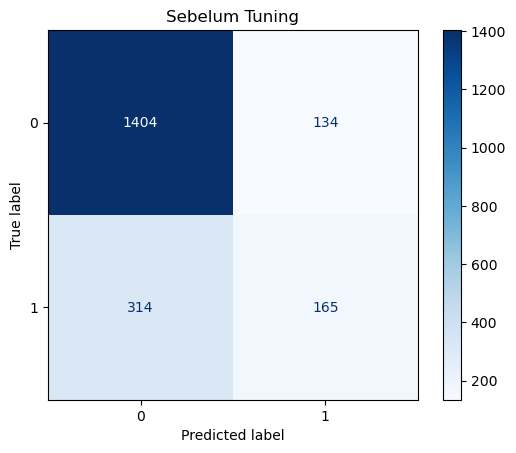

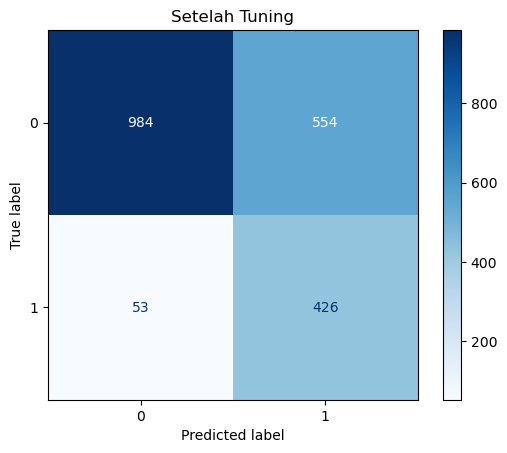

In [258]:
# Menampilkan confusion matrix sebelum tuning dengan warna biru muda
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
disp_before.plot(cmap='Blues')  
plt.title('Sebelum Tuning')

# Menampilkan confusion matrix setelah tuning dengan warna hijau pastel
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot(cmap='Blues')  
plt.title('Setelah Tuning')

plt.show()

### **Analisis Perubahan Sebelum dan Setelah Hyperparameter Tuning**

**Sebelum Tuning:**
- `True Negatives (TN)`  → **1404**  <br><br>
  Model berhasil mengidentifikasi 1404 sampel negatif secara benar.<br><br>
- `False Positives (FP)`  → **134**  <br><br>
  Sebanyak 134 sampel negatif diklasifikasikan salah sebagai positif.<br><br>
- `False Negatives (FN)` → **314**  <br><br>
  Ada 314 sampel positif yang tidak terdeteksi dengan benar dan diklasifikasikan sebagai negatif.<br><br>
- `True Positives (TP)`  → **165**<br><br>
  Model hanya berhasil mengidentifikasi 165 sampel positif secara benar.<br><br>

**Setelah Tuning:**
- `True Negatives (TN)` →  **984**  <br><br>
  Jumlah TN menurun menjadi 984, yang berarti lebih banyak sampel negatif salah diklasifikasikan setelah tuning.<br><br>
- `False Positives (FP)`→  **554**  <br><br>
  Terjadi peningkatan signifikan pada jumlah FP menjadi 554, menunjukkan lebih banyak kesalahan dalam mengklasifikasikan sampel negatif sebagai positif.<br><br>
- `False Negatives (FN)` → **53**<br><br>
  FN turun drastis menjadi 53, menunjukkan bahwa model menjadi jauh lebih baik dalam mengidentifikasi sampel positif.<br><br>
- `True Positives (TP)` →  **426** <br><br>
  TP meningkat menjadi 426, mencerminkan kemampuan model yang lebih baik dalam mendeteksi sampel positif.<br><br>

---

### **Kesimpulan Perubahan:**
1. **Peningkatan Recall:**  
   Setelah tuning, jumlah `FN` menurun signifikan dari **314** menjadi **53**, dan `TP` meningkat dari **165** menjadi **426**. Ini menunjukkan bahwa model lebih fokus pada deteksi sampel positif, sehingga recall meningkat.

2. **Penurunan Precision:**  
   Peningkatan `FP` dari **134** menjadi **554** menurunkan presisi model karena lebih banyak sampel negatif yang salah diklasifikasikan sebagai positif.



# **5.Model 2**

-----

- Dalam proses analisis, nilai pada kolom country diubah untuk menyederhanakan proses pemodelan. Semua negara yang memiliki jumlah kemunculan (count value) **kurang dari 5** digabungkan ke dalam kategori baru bernama `Other`.

- Alasan Pengelompokan adalah untuk menyederhanakan kolom country yang memiliki terlalu banyak nilai unik. Hal ini dilakukan karena jumlah kategori yang berlebihan dapat meningkatkan kompleksitas model dan membuatnya sulit mengenali pola yang signifikan. Dengan menggabungkan nilai-nilai yang jarang muncul ke dalam satu kategori, model dapat bekerja lebih efisien dan fokus pada informasi yang relevan.

### **5.1. EDA**

#### **5.1.1 Copy Data**

In [262]:
df4 = df2.copy()
df4.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


#### **5.1.2 Unique Values**

In [263]:
# Menampilkan nilai unik per kolom
pd.set_option('display.max_colwidth', None)
listItem = []
for col in df4.columns :
 
    listItem.append( [col, df4[col].nunique(), df4[col].unique()   ])

unique_values = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
unique_values

,Column Name,Number of Unique,Unique Sample
0,country,102,"[IRL, FRA, PRT, NLD, ESP, Other, CN, LUX, BRA, BEL, JPN, DEU, ITA, CHE, GBR, AGO, SRB, COL, CHN, SWE, AUT, CZE, POL, USA, SGP, RUS, ROU, DNK, IND, MAR, PHL, ARG, ISL, ZAF, LBN, MOZ, TUR, BGD, MEX, NOR, FIN, UKR, EGY, ISR, KOR, AZE, HUN, AUS, EST, CHL, SVN, ALB, LTU, ARE, HRV, SAU, NZL, LVA, KAZ, DZA, TWN, CRI, BIH, BGR, IRQ, OMN, VEN, IDN, GEO, MLT, IRN, BLR, URY, LBY, TUN, MYS, GRC, CYP, CPV, HKG, PRI, MKD, PAN, NGA, PER, QAT, SEN, SVK, ECU, MDV, THA, JEY, JOR, AND, ARM, GIB, VNM, PAK, JAM, DOM, ...]"
1,market_segment,7,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation]"
2,previous_cancellations,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19, 5, 21]"
3,booking_changes,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12, 14, 21, 16, 20, 15]"
4,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31, 122, 34, 57, 259, 50, 17, 32, 43, 75, 69, 44, 22, 113, 58, 38, 65, 48, 236, 176, 25, 108, 91, 19, 160, 68, 28, 63, 35, 42, 59, 24, 8, 183, 187, 21, 111, 56, 98, 101, 15, 16, 47, 93, 45, 14, 70, 10, 49, 178, 99, 60, 40, 85, 223, 6, 33, 391, 20, 1, 41, 147, 55, 80, 379, 150, 61, 330, 174, 107, 96, 18, 62, 13, 30, 120, 27, 207, 71, 2, 76, 125, 5, 9, 224, 53, 83, 84, 12, ...]"
6,customer_type,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,10,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,6,"[0, 2, 1, 3, 4, 5]"


#### **5.1.3 Simplifying the country Column by Combining Less Frequent Categories**

Proses di bawah bertujuan untuk mengelompokkan negara-negara pada kolom country yang memiliki frekuensi kurang dari 5 menjadi kategori `Other`. 

In [267]:
# Menghitung jumlah kemunculan (count value) dari setiap nilai unik pada kolom 'country'
country_counts = df4['country'].value_counts()

In [269]:
# Mengelompokkan nilai pada kolom 'country' menjadi 'Other' jika jumlahnya kurang dari 5
df4['country'] = df4['country'].apply(
    lambda x: x if country_counts[x] >= 6 else 'Other'
)


# Menampilkan jumlah kategori baru setelah pengelompokan
display(df4['country'].value_counts())

country
PRT    1992
GBR     734
ESP     641
FRA     612
DEU     432
       ... 
PAN       6
MKD       6
PRI       6
IRQ       6
GIB       6
Name: count, Length: 93, dtype: int64

### **5.3. Preprocessing for Modeling 2**

#### **5.3.1. Define X and y**

In [270]:
# Memisahkan fitur (X) dan target (y)
X = df4.drop(columns=['is_canceled'], axis=1)  
y = df4['is_canceled']  

#### **5.3.2. Data Splitting**

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    stratify= y,
                                                    test_size=0.2, 
                                                    random_state=0)

#### **5.3.3. Encoding and Scaling**

In [272]:
# Mapping untuk Ordinal Encoding
ordinal_encoder = [{'col': 'reserved_room_type',
                    'mapping': {'A': 1, 'E': 2, 'D': 3, 'F': 4, 'B': 5, 'G': 6, 'C': 7, 'H': 8, 'P': 9}}]

In [273]:
# Membuat ColumnTransformer untuk preprocessing
transformer = ColumnTransformer([
    # One-Hot Encoding untuk kolom dengan kategori sedikit
    ('one hot encoding', OneHotEncoder(drop='first'), ['deposit_type', 'customer_type']),
    
    # Binary Encoding untuk kolom dengan kategori banyak
    ('binary encoding', BinaryEncoder(), ['country', 'market_segment']),
    
    # Ordinal Encoding untuk kolom dengan nilai ordinal
    ('ordinal_encoding', OrdinalEncoder(mapping=ordinal_encoder, cols=['reserved_room_type']), ['reserved_room_type']),
    
    # Robust Scaler untuk normalisasi fitur numerik
    ('robust scaler', RobustScaler(), [
        'previous_cancellations', 
        'booking_changes', 
        'days_in_waiting_list', 
        'required_car_parking_spaces', 
        'total_of_special_requests'
    ]),
], remainder='passthrough')  

# Menampilkan struktur transformer
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('one hot encoding',
                                 OneHotEncoder(drop='first'),
                                 ['deposit_type', 'customer_type']),
                                ('binary encoding', BinaryEncoder(),
                                 ['country', 'market_segment']),
                                ('ordinal_encoding',
                                 OrdinalEncoder(cols=['reserved_room_type'],
                                                mapping=[{'col': 'reserved_room_type',
                                                          'data_type': dtype('O'),
                                                          'mapping': A    1
E    2
D    3
F    4
B    5
G    6
C    7
H    8
P    9
dtype: int64}]),
                                 ['reserved_room_type']),
                                ('robust scaler', RobustScaler(),
                                 ['previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests'])])

### **5.4. Modeling 2**

#### **5.4.1 Model Selection**

In [277]:
# Mendefinisikan daftar model yang akan dievaluasi
tree = DecisionTreeClassifier(random_state=0)
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
forest = RandomForestClassifier(random_state=0)
adaboost = AdaBoostClassifier(random_state=0)
gradient = GradientBoostingClassifier(random_state=0)
xgboost = xgb.XGBClassifier(random_state=0)

# Daftar model
list_model = [tree, forest, adaboost, gradient, xgboost, logreg, knn]

# Inisialisasi list untuk menyimpan hasil evaluasi
list_score = []
list_mean = []
list_std = []

# Iterasi untuk setiap model
for model in list_model:
    try:
        # Membuat Stratified K-Fold untuk membagi data menjadi 5 fold secara stratifikasi
        cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        
        # Membuat pipeline: gabungan preprocessing dan model
        pipe_prep_model_2 = Pipeline([
            ('preprocessing', transformer),  
            ('model', model)  
        ])
        
        # Melakukan cross-validation
        cv_score_2 = cross_val_score(
            estimator=pipe_prep_model_2,
            cv=cv5,  # Menggunakan Stratified K-Fold
            scoring=scoring_f2,         
            X=X_train,                  
            y=y_train,                  
            n_jobs=-1  # Paralelisasi
        )
        
        # Menyimpan hasil skor ke dalam list
        list_score.append(cv_score_2.round(2))
        list_mean.append(cv_score_2.mean())
        list_std.append(cv_score_2.std())
    
    except Exception as e:
        # Jika ada error, tampilkan pesan error dan tambahkan None ke list hasil
        print(f"Error pada model {model}: {e}")
        list_score.append(None)
        list_mean.append(None)
        list_std.append(None)



/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

In [278]:
while len(list_score) < len(list_model):
    list_score.append(None)

while len(list_mean) < len(list_model):
    list_mean.append(None)

while len(list_std) < len(list_model):
    list_std.append(None)

In [279]:
df4_score = pd.DataFrame({
    'model': [tree, forest, adaboost, gradient, xgboost, logreg, knn],
    'f2 score': list_score,
    'f2 mean': list_mean,
    'f2 std': list_std
})

# Mengurutkan DataFrame berdasarkan rata-rata skor F2 (f2 mean)
df4_score = df4_score.sort_values('f2 mean', ascending=False)
display(df4_score)



,model,f2 score,f2 mean,f2 std
4,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=0, ...)","[0.37, 0.34, 0.36, 0.43, 0.39]",0.378791,0.027731
2,AdaBoostClassifier(random_state=0),"[0.33, 0.32, 0.28, 0.35, 0.37]",0.331247,0.031799
6,KNeighborsClassifier(),"[0.33, 0.32, 0.31, 0.34, 0.34]",0.330094,0.010339
1,RandomForestClassifier(random_state=0),"[0.31, 0.3, 0.3, 0.33, 0.32]",0.311773,0.012114
0,DecisionTreeClassifier(random_state=0),"[0.28, 0.31, 0.29, 0.33, 0.31]",0.301725,0.016442
5,LogisticRegression(random_state=0),"[0.3, 0.26, 0.29, 0.3, 0.31]",0.291924,0.014516
3,GradientBoostingClassifier(random_state=0),"[0.27, 0.29, 0.26, 0.32, 0.32]",0.291358,0.025739


Dua model dengan skor tertinggi dalam dataframe adalah `AdaBoost` dan `XGBoost`. Keduanya memiliki performa yang baik, sehingga perlu dilakukan evaluasi lebih lanjut untuk menentukan model yang lebih unggul.

#### **5.4.2 Handling Imbalance Data**

 **5.4.2.1 Handling Imbalance Data (XGBoost)**

In [280]:
# Define model
xgboost = xgb.XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')  # Model yang akan dievaluasi adalah XGBoost

# Daftar metode resampling yang akan dicoba
list_resampler = [None, smote, ros, rus, nm]  

# Inisialisasi list untuk menyimpan hasil evaluasi
score = []  
list_mean = []  
list_std = []  

# Iterasi untuk setiap metode resampling
for resampler in list_resampler:
    # Membuat Stratified K-Fold untuk cross-validation dengan 5 fold
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    # Membuat pipeline: preprocessing, resampling, dan model
    model_pipe_2 = Pipeline([
        ('transform', transformer),  
        ('balancing', resampler),  
        ('model', xgboost)  ])
    
    # Melakukan cross-validation dengan scoring F2 Score
    model_cv_2 = cross_val_score(
        model_pipe_2,  
        X_train,  
        y_train,  
        cv=skfold,  
        scoring=scoring_f2,  
        error_score='raise'  
    )
    
    # Menyimpan hasil evaluasi ke dalam list
    score.append(model_cv_2) 
    list_mean.append(model_cv_2.mean())  
    list_std.append(model_cv_2.std())  



In [281]:
# Membuat DataFrame untuk menyimpan hasil evaluasi
df4_score_resampler = pd.DataFrame({
    'resampler': list_resampler,
    'mean': list_mean,
    'std': list_std,
})

# Mengurutkan DataFrame berdasarkan rata-rata skor F2 secara descending
df4_score_resampler = df4_score_resampler.sort_values('mean', ascending=False)

# Menampilkan hasil evaluasi
display(df4_score_resampler)

,resampler,mean,std
3,RandomUnderSampler(random_state=0),0.697736,0.005719
2,RandomOverSampler(random_state=0),0.681006,0.016319
1,SMOTE(random_state=0),0.456605,0.019015
4,NearMiss(sampling_strategy='majority'),0.430388,0.020963
0,None,0.378791,0.027731


 **5.4.2.2 Handling Imbalance Data(AdaBoost)**

In [284]:
# Define model
adaboost = AdaBoostClassifier(random_state=0)

# Daftar metode resampling yang akan dicoba
list_resampler = [None, smote, ros, rus, nm]

# Inisialisasi list untuk menyimpan hasil evaluasi
score = []
list_mean = []
list_std = []
list_recall_test = []

# Iterasi untuk setiap metode resampling
for resampler in list_resampler:
    # Membuat Stratified K-Fold untuk cross-validation dengan 5 fold
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    # Membuat pipeline: preprocessing, resampling, dan model
    model_pipe_2 = Pipeline([
        ('transform', transformer),
        ('balancing', resampler),
        ('model', adaboost)
    ])
    
    # Melakukan cross-validation dengan scoring F2 Score
    model_cv_2 = cross_val_score(
        model_pipe_2,
        X_train,
        y_train,
        cv=skfold,
        scoring=scoring_f2,
        error_score='raise'
    )
    
    # Menyimpan hasil evaluasi ke dalam list
    score.append(model_cv_2)
    list_mean.append(model_cv_2.mean())
    list_std.append(model_cv_2.std())


In [285]:
# Membuat DataFrame untuk menyimpan hasil evaluasi
df4_score_resampler = pd.DataFrame({
    'resampler': list_resampler, 
    'mean': list_mean,  
    'std': list_std,  
})

# Mengurutkan DataFrame berdasarkan rata-rata skor F2 secara descending
df4_score_resampler = df4_score_resampler.sort_values('mean', ascending=False)

# Menampilkan hasil evaluasi
display(df4_score_resampler)

,resampler,mean,std
3,RandomUnderSampler(random_state=0),0.675641,0.012599
2,RandomOverSampler(random_state=0),0.675600,0.009051
1,SMOTE(random_state=0),0.608035,0.016182
4,NearMiss(sampling_strategy='majority'),0.473884,0.023456
0,None,0.331247,0.031799


Kedua model, baik `AdaBoost` maupun `XGBoost`, menggunakan **RandomUnderSampler** sebagai metode untuk menangani masalah ketidakseimbangan data.

#### **5.4.3 Hyperparameter Tuning**

 **5.4.3.1 Hyperparameter Tuning (AdaBoost)**

In [286]:
# Mendefinisikan ruang pencarian hyperparameter untuk AdaBoost
search_space_adaboost = {
    'model__n_estimators': [50, 100, 200, 300, 500],
    'model__learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5],
    'model__algorithm': ['SAMME', 'SAMME.R']
}

# Membuat pipeline yang menggabungkan preprocessing, resampling, dan model
pipe_prep_model_adaboost = Pipeline([
    ('preprocessing', transformer),
    ('balancing', rus),
    ('model', AdaBoostClassifier(random_state=0))
])

# Mengatur BayesSearchCV untuk optimasi hyperparameter
bayes_search_adaboost = BayesSearchCV(
    pipe_prep_model_adaboost,
    search_space_adaboost,
    n_iter=50,
    scoring=scoring_f2,
    cv=5,
    n_jobs=-1,
    random_state=0,
)

# Melatih BayesSearchCV pada data latih
bayes_search_adaboost.fit(X_train, y_train)

# Menampilkan hyperparameter terbaik dan skor terbaik
print("Best parameters:", bayes_search_adaboost.best_params_)
print("Best score:", bayes_search_adaboost.best_score_)




/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Best parameters: OrderedDict({'model__algorithm': 'SAMME.R', 'model__learning_rate': 0.1, 'model__n_estimators': 100})
Best score: 0.6941585557534331


In [288]:
# Pipeline dengan kombinasi hyperparameter terbaik
bayes_search_adaboost.best_estimator_



Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary encoding',
                                                  BinaryEncoder(),
                                                  ['country',
                                                   'market_segment']),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(cols=['reserved_room_type'],
                                                                 mapping=[{'col': 'reserved_room_type',
                                                                           'data_type': dtype...
                                                                           'mapping': A    1
E    2
D    3
F    4
B    5
G    6
C    7
H    8
P    9
dtype: int64}]),
                                                  ['reserved_room_type']),
                                                 ('robust scaler',
                                                  RobustScaler(),
                                                  ['previous_cancellations',
                                                   'booking_changes',
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests'])])),
                ('balancing', RandomUnderSampler(random_state=0)),
                ('model',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=100,
                                    random_state=0))])

In [289]:
# Parameter terbaik untuk AdaBoost
bayes_search_adaboost.best_params_

OrderedDict([('model__algorithm', 'SAMME.R'),
             ('model__learning_rate', 0.1),
             ('model__n_estimators', 100)])

 **5.4.3.2 Hyperparameter Tuning (XGBoost)**

In [290]:
# Mendefinisikan ruang pencarian hyperparameter untuk XGBoost
search_space_xgb = {
    'model__n_estimators': Integer(50, 1000),  
    'model__max_depth': Integer(3, 10),  
    'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'), 
    'model__subsample': Real(0.5, 1.0),  
    'model__colsample_bytree': Real(0.5, 1.0),  
    'model__gamma': Real(0, 5),  
    'model__scale_pos_weight': Real(1, 10)  
}

# Membuat pipeline dengan preprocessing, resampling, dan model XGBoost
pipe_prep_model_xgb = Pipeline([
    ('preprocessing', transformer),  
    ('balancing', rus), 
    ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))  
])

# Mengatur BayesSearchCV untuk pencarian hyperparameter
bayes_search_xgb = BayesSearchCV(
    pipe_prep_model_xgb, 
    search_space_xgb,  
    n_iter=100,  
    scoring=scoring_f2,  
    cv=5, 
    n_jobs=-1,  
    random_state=0,  
)

# Melatih BayesSearchCV pada data pelatihan
bayes_search_xgb.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", bayes_search_xgb.best_params_)  
print("Best score:", bayes_search_xgb.best_score_)  


/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:48:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are no

Best parameters: OrderedDict({'model__colsample_bytree': 1.0, 'model__gamma': 2.0833981057437394, 'model__learning_rate': 0.010822942950908947, 'model__max_depth': 10, 'model__n_estimators': 763, 'model__scale_pos_weight': 2.0238770583941563, 'model__subsample': 0.6809224478817772})
Best score: 0.7425997760472189


---
Berdasarkan evaluasi, skor terbaik yang dicapai oleh `XGBoost` adalah **0.74**, sedangkan `XGBoost` memiliki skor yang lebih tinggi yaitu **0.69**. <br><br> Karena `XGBoost` memiliki performa yang lebih baik dibandingkan `AdaBoost` dalam hal F2 Score, maka model yang akan digunakan untuk analisis akhir adalah `XGBoost`.


In [317]:
# Menampilkan pipeline estimator terbaik dari BayesSearchCV
bayes_search_xgb.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary encoding',
                                                  BinaryEncoder(),
                                                  ['country',
                                                   'market_segment']),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(cols=['reserved_room_type'],
                                                                 mapping=[{'col': 'reserved_room_type',
                                                                           'data_type': dtype...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.02266471861458564, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=755,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [318]:
# Menyimpan model hasil tuning ke dalam file menggunakan pickle
with open(r'capstone real\hotel_booking_model.sav', 'wb') as model_file:
    pickle.dump(bayes_search_xgb.best_estimator_, model_file)


In [319]:
# Menampilkan parameter terbaik dari hasil tuning
bayes_search_xgb.best_params_

OrderedDict([('model__colsample_bytree', 1.0),
             ('model__gamma', 4.158501956927305),
             ('model__learning_rate', 0.02266471861458564),
             ('model__max_depth', 4),
             ('model__n_estimators', 755),
             ('model__scale_pos_weight', 1.87721699447546),
             ('model__subsample', 0.5)])

In [321]:
# Membandingkan skor sebelum dan sesudah re-modelling
print("Best Score before re-modelling:", bayes_search.best_score_)
print("Best score after re-modelling:", bayes_search_xgb.best_score_)
print("Improvement:", bayes_search_xgb.best_score_ - bayes_search.best_score_)

Best Score before re-modelling: 0.7360089060074823
Best score after re-modelling: 0.7439682323510182
Improvement: 0.00795932634353591


---
Setelah dilakukan pemrosesan ulang dan optimasi model, terdapat peningkatan pada skor F2 sebesar **0.00795932634353591**. <br><br>Meskipun peningkatan ini terbilang kecil, hal ini tetap menunjukkan adanya perbaikan dalam performa model.
<br><br>
Untuk meningkatkan performa model lebih lanjut, dapat dicoba pengaturan ulang threshold klasifikasi guna melihat apakah terdapat peningkatan tambahan pada performa model.

#### **5.4.5 Testing Model Performance**

**Sebelum Tuning**

In [322]:
# Mendefinisikan model
model = xgboost

# Membuat pipeline untuk preprocessing dan model
pipe_prep_model_before_2 = Pipeline([
    ('preprocessing', transformer),  
    ('model', model)                 
])

# Melatih pipeline dengan data latih
pipe_prep_model_before_2.fit(X_train, y_train)

# Membuat prediksi pada data uji (hasil berupa 0/1)
y_pred_before_2 = pipe_prep_model_before_2.predict(X_test)
y_pred_before_2

# Menghitung F2 Score dengan threshold default (0.5)
f2_score_before = fbeta_score(y_test, y_pred_before_2, beta=2)
f2_score_before

0.3778280542986425

**Setelah Tuning**

In [323]:
# Mendefinisikan model setelah tuning
model_after = bayes_search.best_estimator_

# Melatih model dengan hyperparameter terbaik
model_after.fit(X_train, y_train)

# Memprediksi data uji
y_pred_after = model_after.predict(X_test)

# Menghitung F2 Score setelah tuning
f2_score_after = fbeta_score(y_test, y_pred_after, beta=2)
f2_score_after  

0.745674740484429

**Kesimpulan Evaluasi Model**

- `F2 Score` pada data uji sebelum dan sesudah tuning menunjukkan perbedaan yang signifikan. `F2 Score` sebelum tuning adalah **0.37**, sedangkan setelah tuning meningkat menjadi **0.74**.<br><br>
- Tidak terdapat indikasi overfitting pada model karena `F2 Score` pada data uji lebih tinggi dibandingkan dengan `F2 Score` pada data latih.<br><br>
- Selain itu, model dapat dikategorikan sebagai generalisasi yang baik karena perbedaan `F2 Score` antara data uji dan data latih tidak terlalu jauh.

#### **5.4.6. Confussion Matrix Model 2**

In [324]:
# Membuat confusion matrix sebelum tuning
cm_before = confusion_matrix(y_test, y_pred_before)

# Membuat confusion matrix setelah tuning
cm_after = confusion_matrix(y_test, y_pred_after)

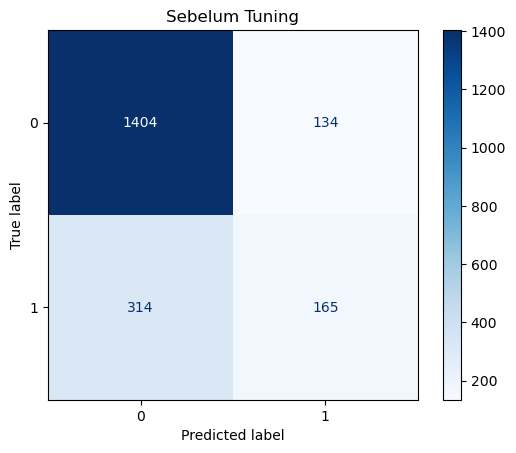

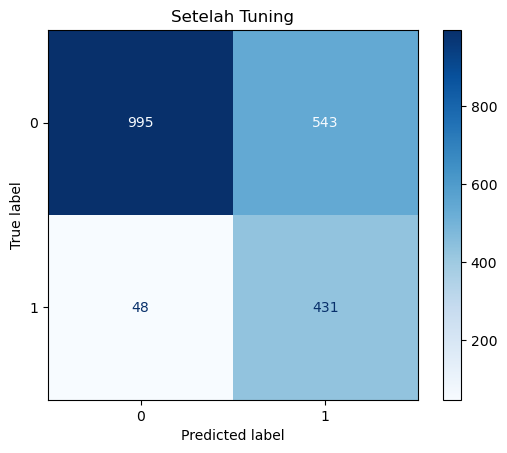

In [325]:
# Menampilkan confusion matrix sebelum tuning dengan warna biru muda
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
disp_before.plot(cmap='Blues')  
plt.title('Sebelum Tuning')

# Menampilkan confusion matrix setelah tuning dengan warna hijau pastel
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot(cmap='Blues')  
plt.title('SetelahTuning ')

plt.show()

### **Analisis Perubahan Sebelum dan Setelah Tuning**

**Sebelum Tuning**

- `True Negatives (TN)` →  **1404**<br><br>
TN tetap berada di angka 1404, artinya langkah pengelompokan negara tidak memengaruhi performa awal model dalam mengenali pemesanan yang tidak dibatalkan. <br><br>

- `False Positives (FP)` →  **134** <br><br>
    FP tetap 134, menunjukkan bahwa model masih memiliki tingkat kesalahan yang sama dalam memprediksi pembatalan yang sebenarnya tidak terjadi. <br><br>
-  `False Negatives (FN)` → **314** <br><br>
    FN tetap 314, artinya performa model dalam mendeteksi pembatalan belum berubah. <br><br>

- `True Positives (TP)` → **165** <br><br>
    TP tetap 165, menandakan bahwa baseline performa recall belum berubah sebelum tuning.<br><br>

**Setelah Tuning**

- `True Negatives (TN)` → **995**<br><br>
    TN meningkat menjadi 995, artinya model menjadi lebih baik dalam mengenali pemesanan yang benar-benar tidak dibatalkan setelah pengelompokan negara.<br><br>

- `False Positives (FP)` → **543** <br><br>
    FP menurun sedikit menjadi 543, menunjukkan bahwa pengelompokan negara membantu mengurangi kesalahan saat memprediksi pembatalan pada pemesanan yang tidak dibatalkan.

- `False Negatives (FN)` → **48**<br><br>
    FN menurun menjadi 48, artinya model menjadi lebih baik dalam mendeteksi pembatalan setelah pengelompokan negara.<br><br>

- `True Positives (TP)` → **431**<br><br>
    TP meningkat menjadi 431, menunjukkan performa recall yang semakin baik, di mana model dapat lebih sering mendeteksi pembatalan dengan benar.<br><br>

**Kesimpulan**

Setelah pengelompokan negara ke dalam kategori **Other**, model menunjukkan peningkatan performa. **False Negatives (FN)** turun dari **314 menjadi 48**, dan **True Positives (TP)** meningkat dari **165 menjadi 431**, menunjukkan kemampuan model yang lebih baik dalam mendeteksi pembatalan.

Selain itu, penurunan **False Positives (FP)** dari **554 menjadi 543** menunjukkan bahwa risiko overbooking tetap terkendali. Langkah ini mendukung tujuan utama model untuk meminimalkan False Negatives tanpa meningkatkan False Positives secara berlebihan, sehingga membantu hotel mengoptimalkan operasional dan pendapatan.

## **6. Model 3**

-----

- Pada model ini, dilakukan pendekatan khusus untuk menambahkan informasi tambahan ke dalam dataset dengan cara menciptakan fitur-fitur baru. Proses ini bertujuan untuk meningkatkan performa model prediksi, khususnya dalam mendeteksi pembatalan pemesanan hotel (is_canceled). <br><br>

- Penambahan fitur dilakukan dengan cara menggabungkan atau mentransformasi data yang sudah ada, sehingga menciptakan pola baru yang mungkin lebih relevan dan mudah dikenali oleh model.<br><br>

- **Fitur tambahan yang dirancang mencakup:**

1. `total_service_requests`<br>
 Jumlah total permintaan khusus, termasuk permintaan ruang parkir.<br><br>
2. `cancellation_history`<br>
 Indikator apakah tamu pernah membatalkan pemesanan sebelumnya.<br><br>
3. `change_request_rate`<br
 Rasio perubahan permintaan terhadap waktu tunggu pemesanan.<br><br>
4. `special_request_intensity`<br>
 Intensitas permintaan khusus dibandingkan dengan total permintaan.<br><br>
5. `is_long_wait`<br>
 Indikator apakah waktu tunggu pemesanan lebih dari satu minggu.<br><br>

### **6.1. EDA**

#### **6.1.1 Copy Data**

In [329]:
df6 = df4.copy()
df6.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


#### **6.1.2 Unique Values**

In [330]:
# Menampilkan nilai unik per kolom
pd.set_option('display.max_colwidth', None)
listItem = []
for col in df6.columns :
 
    listItem.append( [col, df6[col].nunique(), df6[col].unique()   ])

unique_values = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Sample'],
                     data=listItem)
unique_values

,Column Name,Number of Unique,Unique Sample
0,country,93,"[IRL, FRA, PRT, NLD, ESP, Other, CN, LUX, BRA, BEL, JPN, DEU, ITA, CHE, GBR, AGO, SRB, COL, CHN, SWE, AUT, CZE, POL, USA, SGP, RUS, ROU, DNK, IND, MAR, PHL, ARG, ISL, ZAF, LBN, MOZ, TUR, MEX, NOR, FIN, UKR, EGY, ISR, KOR, AZE, HUN, AUS, EST, CHL, SVN, LTU, ARE, HRV, SAU, NZL, LVA, KAZ, DZA, TWN, CRI, BIH, BGR, IRQ, OMN, VEN, IDN, GEO, MLT, IRN, BLR, URY, TUN, MYS, GRC, CYP, CPV, HKG, PRI, MKD, PAN, NGA, PER, QAT, SEN, SVK, ECU, MDV, THA, JOR, GIB, PAK, DOM, KWT]"
1,market_segment,7,"[Offline TA/TO, Online TA, Direct, Groups, Corporate, Complementary, Aviation]"
2,previous_cancellations,15,"[0, 1, 25, 2, 3, 11, 24, 13, 6, 26, 14, 4, 19, 5, 21]"
3,booking_changes,19,"[0, 1, 2, 5, 3, 4, 6, 7, 9, 8, 17, 10, 13, 12, 14, 21, 16, 20, 15]"
4,deposit_type,3,"[No Deposit, Non Refund, Refundable]"
5,days_in_waiting_list,115,"[0, 3, 39, 87, 77, 215, 97, 162, 46, 79, 4, 31, 122, 34, 57, 259, 50, 17, 32, 43, 75, 69, 44, 22, 113, 58, 38, 65, 48, 236, 176, 25, 108, 91, 19, 160, 68, 28, 63, 35, 42, 59, 24, 8, 183, 187, 21, 111, 56, 98, 101, 15, 16, 47, 93, 45, 14, 70, 10, 49, 178, 99, 60, 40, 85, 223, 6, 33, 391, 20, 1, 41, 147, 55, 80, 379, 150, 61, 330, 174, 107, 96, 18, 62, 13, 30, 120, 27, 207, 71, 2, 76, 125, 5, 9, 224, 53, 83, 84, 12, ...]"
6,customer_type,4,"[Transient-Party, Transient, Contract, Group]"
7,reserved_room_type,10,"[A, E, D, F, B, G, C, H, L, P]"
8,required_car_parking_spaces,5,"[0, 1, 2, 8, 3]"
9,total_of_special_requests,6,"[0, 2, 1, 3, 4, 5]"


### **6.2. Preprocessing for Modeling 3**

#### **6.2.1 Feature Creation**

In [334]:

# Transformer khusus untuk membuat fitur baru
class FeatureCreation(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        # Pastikan X adalah DataFrame
        X = pd.DataFrame(X)
        # Pembuatan fitur baru
        X['total_service_requests'] = X['total_of_special_requests'] + X['required_car_parking_spaces']
        X['cancellation_history'] = np.where(X['previous_cancellations'] > 0, 1, 0)
        X['change_request_rate'] = X['booking_changes'] / (X['days_in_waiting_list'] + 1)
        X['special_request_intensity'] = X['total_of_special_requests'] / (X['total_of_special_requests'] + X['required_car_parking_spaces'] + 1)
        X['is_long_wait'] = np.where(X['days_in_waiting_list'] > 7, 1, 0)
        return X


In [337]:
# Inisialisasi transformer
feature_transformer = FeatureCreation()

# Terapkan transformasi ke df6
df6_transformed = feature_transformer.transform(df6)

# Menampilkan beberapa baris pertama dari dataset yang telah diubah
df6_transformed.head()


,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,total_service_requests,cancellation_history,change_request_rate,special_request_intensity,is_long_wait
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0,0,0,0.0,0.000000,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0,2,0,0.0,0.666667,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0,2,0,1.0,0.666667,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1,1,0,0.0,0.500000,0
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0,2,0,2.0,0.666667,0


#### **6.2.2. Define X and y**

In [389]:
# Pisahkan fitur (X) dan target (y)
X = df6_transformed.drop('is_canceled', axis=1)
y = df6_transformed['is_canceled']




#### **6.2.3. Data Splitting**

In [361]:


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




Dimensi X_train: (8066, 15), y_train: (8066,)
Dimensi X_test: (2017, 15), y_test: (2017,)


#### **6.2.4. Encoding and Scaling**

In [362]:
# Mapping untuk Ordinal Encoding
ordinal_encoder = [{'col': 'reserved_room_type',
                    'mapping': {'A': 1, 'E': 2, 'D': 3, 'F': 4, 'B': 5, 'G': 6, 'C': 7, 'H': 8, 'P': 9}}]

In [363]:
# Membuat ColumnTransformer untuk preprocessing dengan kolom baru
transformer = ColumnTransformer([
    # One-Hot Encoding untuk kolom dengan kategori sedikit
    ('one hot encoding', OneHotEncoder(drop='first'), ['deposit_type', 'customer_type']),
    
    # Binary Encoding untuk kolom dengan kategori banyak
    ('binary encoding', BinaryEncoder(), ['country', 'market_segment']),
    
    # Ordinal Encoding untuk kolom dengan nilai ordinal
    ('ordinal_encoding', OrdinalEncoder(mapping=ordinal_encoder, cols=['reserved_room_type']), ['reserved_room_type']),
    
    # Robust Scaler untuk normalisasi fitur numerik
    ('robust scaler', RobustScaler(), [
        'previous_cancellations', 
        'booking_changes', 
        'days_in_waiting_list', 
        'required_car_parking_spaces', 
        'total_of_special_requests',
        'total_service_requests',        # Kolom baru
        'change_request_rate',           # Kolom baru
        'special_request_intensity'      # Kolom baru
    ]),

    # Passthrough untuk fitur biner yang tidak memerlukan transformasi
    ('passthrough_binary', 'passthrough', ['cancellation_history', 'is_long_wait'])
], remainder='passthrough')  # Fitur lainnya dilewatkan tanpa perubahan

# Menampilkan struktur transformer
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('one hot encoding',
                                 OneHotEncoder(drop='first'),
                                 ['deposit_type', 'customer_type']),
                                ('binary encoding', BinaryEncoder(),
                                 ['country', 'market_segment']),
                                ('ordinal_encoding',
                                 OrdinalEncoder(cols=['reserved_room_type'],
                                                mapping=[{'col': 'reserved_room_type',
                                                          'data_type': dtype('O'),
                                                          'mapping': A    1
E    2
D    3
F    4
B    5
G    6
C    7
H    8
P...
dtype: int64}]),
                                 ['reserved_room_type']),
                                ('robust scaler', RobustScaler(),
                                 ['previous_cancellations', 'booking_changes',
                                  'days_in_waiting_list',
                                  'required_car_parking_spaces',
                                  'total_of_special_requests',
                                  'total_service_requests',
                                  'change_request_rate',
                                  'special_request_intensity']),
                                ('passthrough_binary', 'passthrough',
                                 ['cancellation_history', 'is_long_wait'])])

---

**Penyesuaian yang Dilakukan** 
<br><br>

**1. Kolom Baru dengan** `Robust Scaler`<br><br>
- `total_service_requests`<br><br>
- `change_request_rate`<br><br>
- `special_request_intensity`<br><br>

Kolom ini ditambahkan karena nilai-nilainya adalah **numerik kontinu**, sehingga perlu dinormalisasi untuk mengurangi pengaruh outlier.<br><br>

    
**2. Kolom Baru dengan Passthrough** <br><br>

`cancellation_history` dan `is_long_wait` adalah **kolom biner**, sehingga tidak memerlukan scaling. Kolom ini dilewatkan langsung ke pipeline tanpa transformasi.

**3. Kolom Lama Tetap**<br><br>
 Semua kolom lama tetap berada pada bagian preprocessing yang sama seperti sebelumnya.

### **6.3. Modeling 3**

#### **6.3.1 Model Selection**

In [370]:
# Uji preprocessing pipeline
transformed_X_train = transformer.fit_transform(X_train)



In [371]:
# Tambahkan FeatureCreation sebagai langkah pertama
transformer_with_feature_creation = Pipeline([
    ('feature_creation', FeatureCreation()),  # Langkah pertama untuk membuat fitur baru
    ('preprocessing', transformer)           # Langkah kedua: preprocessing
])


In [372]:
# Mendefinisikan daftar model yang akan dievaluasi
tree = DecisionTreeClassifier(random_state=0)
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
forest = RandomForestClassifier(random_state=0)
adaboost = AdaBoostClassifier(random_state=0)
gradient = GradientBoostingClassifier(random_state=0)
xgboost = xgb.XGBClassifier(random_state=0)

# Daftar model
list_model = [tree, forest, adaboost, gradient, xgboost, logreg, knn]

# Inisialisasi list untuk menyimpan hasil evaluasi
list_score = []
list_mean = []
list_std = []

# Iterasi untuk setiap model
for model in list_model:
    try:
        # Membuat Stratified K-Fold untuk membagi data menjadi 5 fold secara stratifikasi
        cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
        
        # Membuat pipeline: gabungan preprocessing dan model
        pipe_prep_model_2 = Pipeline([
            ('preprocessing', transformer),  
            ('model', model)  
        ])
        
        # Melakukan cross-validation
        cv_score_2 = cross_val_score(
            estimator=pipe_prep_model_2,
            cv=cv5,  # Menggunakan Stratified K-Fold
            scoring=scoring_f2,         
            X=X_train,                  
            y=y_train,                  
            n_jobs=-1  # Paralelisasi
        )
        
        # Menyimpan hasil skor ke dalam list
        list_score.append(cv_score_2.round(2))
        list_mean.append(cv_score_2.mean())
        list_std.append(cv_score_2.std())
    
    except Exception as e:
        # Jika ada error, tampilkan pesan error dan tambahkan None ke list hasil
        print(f"Error pada model {model}: {e}")
        list_score.append(None)
        list_mean.append(None)
        list_std.append(None)



/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

In [373]:
while len(list_score) < len(list_model):
    list_score.append(None)

while len(list_mean) < len(list_model):
    list_mean.append(None)

while len(list_std) < len(list_model):
    list_std.append(None)

In [374]:
df6_score = pd.DataFrame({
    'model': [tree, forest, adaboost, gradient, xgboost, logreg, knn],
    'f2 score': list_score,
    'f2 mean': list_mean,
    'f2 std': list_std
})

# Mengurutkan DataFrame berdasarkan rata-rata skor F2 (f2 mean)
df6_score = df6_score.sort_values('f2 mean', ascending=False)
display(df6_score)

,model,f2 score,f2 mean,f2 std
4,"XGBClassifier(base_score=None, booster=None, callbacks=None,\n colsample_bylevel=None, colsample_bynode=None,\n colsample_bytree=None, device=None, early_stopping_rounds=None,\n enable_categorical=False, eval_metric=None, feature_types=None,\n gamma=None, grow_policy=None, importance_type=None,\n interaction_constraints=None, learning_rate=None, max_bin=None,\n max_cat_threshold=None, max_cat_to_onehot=None,\n max_delta_step=None, max_depth=None, max_leaves=None,\n min_child_weight=None, missing=nan, monotone_constraints=None,\n multi_strategy=None, n_estimators=None, n_jobs=None,\n num_parallel_tree=None, random_state=0, ...)","[0.39, 0.38, 0.32, 0.33, 0.34]",0.353697,0.027681
2,AdaBoostClassifier(random_state=0),"[0.33, 0.35, 0.35, 0.31, 0.29]",0.324407,0.024324
6,KNeighborsClassifier(),"[0.31, 0.34, 0.28, 0.32, 0.29]",0.309799,0.021426
5,LogisticRegression(random_state=0),"[0.31, 0.31, 0.32, 0.29, 0.26]",0.298728,0.021307
1,RandomForestClassifier(random_state=0),"[0.29, 0.32, 0.29, 0.27, 0.25]",0.285247,0.020891
3,GradientBoostingClassifier(random_state=0),"[0.31, 0.3, 0.28, 0.28, 0.24]",0.281144,0.023771
0,DecisionTreeClassifier(random_state=0),"[0.27, 0.28, 0.25, 0.31, 0.26]",0.272858,0.019200


Dua model dengan skor tertinggi dalam dataframe adalah `AdaBoost` dan `XGBoost`. Keduanya memiliki performa yang baik, sehingga perlu dilakukan evaluasi lebih lanjut untuk menentukan model yang lebih unggul.

#### **6.4.2 Handling Imbalance Data**

 **6.4.2.1 Handling Imbalance Data (XGBoost)**

In [375]:
# Define model
xgboost = xgb.XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')  # Model yang akan dievaluasi adalah XGBoost

# Daftar metode resampling yang akan dicoba
list_resampler = [None, smote, ros, rus, nm]  

# Inisialisasi list untuk menyimpan hasil evaluasi
score = []  
list_mean = []  
list_std = []  

# Iterasi untuk setiap metode resampling
for resampler in list_resampler:
    # Membuat Stratified K-Fold untuk cross-validation dengan 5 fold
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    # Membuat pipeline: preprocessing, resampling, dan model
    model_pipe_2 = Pipeline([
        ('transform', transformer),  
        ('balancing', resampler),  
        ('model', xgboost)  ])
    
    # Melakukan cross-validation dengan scoring F2 Score
    model_cv_2 = cross_val_score(
        model_pipe_2,  
        X_train,  
        y_train,  
        cv=skfold,  
        scoring=scoring_f2,  
        error_score='raise'  
    )
    
    # Menyimpan hasil evaluasi ke dalam list
    score.append(model_cv_2) 
    list_mean.append(model_cv_2.mean())  
    list_std.append(model_cv_2.std())  



In [376]:
# Membuat DataFrame untuk menyimpan hasil evaluasi
df6_score_resampler = pd.DataFrame({
    'resampler': list_resampler,
    'mean': list_mean,
    'std': list_std,
})

# Mengurutkan DataFrame berdasarkan rata-rata skor F2 secara descending
df6_score_resampler = df6_score_resampler.sort_values('mean', ascending=False)

# Menampilkan hasil evaluasi
display(df6_score_resampler)

,resampler,mean,std
3,RandomUnderSampler(random_state=0),0.678196,0.015888
2,RandomOverSampler(random_state=0),0.656548,0.014054
4,NearMiss(sampling_strategy='majority'),0.433996,0.020553
1,SMOTE(random_state=0),0.419993,0.029223
0,None,0.353697,0.027681


 **6.4.2.2 Handling Imbalance Data(AdaBoost)**

In [377]:
# Define model
adaboost = AdaBoostClassifier(random_state=0)

# Daftar metode resampling yang akan dicoba
list_resampler = [None, smote, ros, rus, nm]

# Inisialisasi list untuk menyimpan hasil evaluasi
score = []
list_mean = []
list_std = []
list_recall_test = []

# Iterasi untuk setiap metode resampling
for resampler in list_resampler:
    # Membuat Stratified K-Fold untuk cross-validation dengan 5 fold
    skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    
    # Membuat pipeline: preprocessing, resampling, dan model
    model_pipe_2 = Pipeline([
        ('transform', transformer),
        ('balancing', resampler),
        ('model', adaboost)
    ])
    
    # Melakukan cross-validation dengan scoring F2 Score
    model_cv_2 = cross_val_score(
        model_pipe_2,
        X_train,
        y_train,
        cv=skfold,
        scoring=scoring_f2,
        error_score='raise'
    )
    
    # Menyimpan hasil evaluasi ke dalam list
    score.append(model_cv_2)
    list_mean.append(model_cv_2.mean())
    list_std.append(model_cv_2.std())


In [378]:
# Membuat DataFrame untuk menyimpan hasil evaluasi
df6_score_resampler = pd.DataFrame({
    'resampler': list_resampler, 
    'mean': list_mean,  
    'std': list_std,  
})

# Mengurutkan DataFrame berdasarkan rata-rata skor F2 secara descending
df6_score_resampler = df6_score_resampler.sort_values('mean', ascending=False)

# Menampilkan hasil evaluasi
display(df6_score_resampler)

,resampler,mean,std
2,RandomOverSampler(random_state=0),0.670993,0.018876
3,RandomUnderSampler(random_state=0),0.667457,0.017405
1,SMOTE(random_state=0),0.594657,0.023918
4,NearMiss(sampling_strategy='majority'),0.464383,0.015345
0,None,0.324407,0.024324


`AdaBoost` menggunakan **RandomOverSampling** sementara `XGBoost`, menggunakan **RandomUnderSampler** sebagai metode untuk menangani masalah ketidakseimbangan data.

#### **6.4.3 Hyperparameter Tuning**

**6.4.3.1 Hyperparameter Tuning (AdaBoost)**

In [379]:


# Menggunakan RandomOverSampler (ROS) untuk menangani ketidakseimbangan data
ros = RandomOverSampler(random_state=0)

# Mendefinisikan ruang pencarian hyperparameter untuk AdaBoost
search_space_adaboost = {
    'model__n_estimators': [50, 100, 200, 300, 500],
    'model__learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5],
    'model__algorithm': ['SAMME', 'SAMME.R']
}

# Membuat pipeline yang menggabungkan preprocessing, resampling (ROS), dan model
pipe_prep_model_adaboost = Pipeline([
    ('preprocessing', transformer),   
    ('balancing', ros),               
    ('model', AdaBoostClassifier(random_state=0)) 
])

# Mengatur BayesSearchCV untuk optimasi hyperparameter
bayes_search_adaboost = BayesSearchCV(
    pipe_prep_model_adaboost,
    search_space_adaboost,  
    n_iter=50,             
    scoring=scoring_f2,     
    cv=5,                  
    n_jobs=-1,              
    random_state=0          
)

# Melatih BayesSearchCV pada data latih
bayes_search_adaboost.fit(X_train, y_train)

# Menampilkan hyperparameter terbaik dan skor terbaik
print("Best parameters:", bayes_search_adaboost.best_params_)
print("Best score:", bayes_search_adaboost.best_score_)


/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed i

Best parameters: OrderedDict({'model__algorithm': 'SAMME.R', 'model__learning_rate': 0.1, 'model__n_estimators': 100})
Best score: 0.685585594785413


In [380]:
# Pipeline dengan kombinasi hyperparameter terbaik
bayes_search_adaboost.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary encoding',
                                                  BinaryEncoder(),
                                                  ['country',
                                                   'market_segment']),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(cols=['reserved_room_type'],
                                                                 mapping=[{'col': 'reserved_room_type',
                                                                           'data_type': dtype...
                                                   'days_in_waiting_list',
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests',
                                                   'total_service_requests',
                                                   'change_request_rate',
                                                   'special_request_intensity']),
                                                 ('passthrough_binary',
                                                  'passthrough',
                                                  ['cancellation_history',
                                                   'is_long_wait'])])),
                ('balancing', RandomOverSampler(random_state=0)),
                ('model',
                 AdaBoostClassifier(learning_rate=0.1, n_estimators=100,
                                    random_state=0))])

In [381]:
# Parameter terbaik untuk AdaBoost
bayes_search_adaboost.best_params_

OrderedDict([('model__algorithm', 'SAMME.R'),
             ('model__learning_rate', 0.1),
             ('model__n_estimators', 100)])

 **6.4.3.2 Hyperparameter Tuning (XGBoost)**

In [382]:
# Mendefinisikan ruang pencarian hyperparameter untuk XGBoost
search_space_xgb = {
    'model__n_estimators': Integer(50, 1000),  
    'model__max_depth': Integer(3, 10),  
    'model__learning_rate': Real(0.01, 0.3, prior='log-uniform'), 
    'model__subsample': Real(0.5, 1.0),  
    'model__colsample_bytree': Real(0.5, 1.0),  
    'model__gamma': Real(0, 5),  
    'model__scale_pos_weight': Real(1, 10)  
}

# Membuat pipeline dengan preprocessing, resampling, dan model XGBoost
pipe_prep_model_xgb = Pipeline([
    ('preprocessing', transformer),  
    ('balancing', rus), 
    ('model', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))  
])

# Mengatur BayesSearchCV untuk pencarian hyperparameter
bayes_search_xgb = BayesSearchCV(
    pipe_prep_model_xgb, 
    search_space_xgb,  
    n_iter=100,  
    scoring=scoring_f2,  
    cv=5, 
    n_jobs=-1,  
    random_state=0,  
)

# Melatih BayesSearchCV pada data pelatihan
bayes_search_xgb.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", bayes_search_xgb.best_params_)  
print("Best score:", bayes_search_xgb.best_score_)  


/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:20:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:20:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:20:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/silvanadelizea/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [23:20:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are no

Best parameters: OrderedDict({'model__colsample_bytree': 0.9377072916521527, 'model__gamma': 2.672637464273426, 'model__learning_rate': 0.07051581355416366, 'model__max_depth': 7, 'model__n_estimators': 985, 'model__scale_pos_weight': 2.4384194355038904, 'model__subsample': 0.9116949510382424})
Best score: 0.7446977057598682



---
Berdasarkan evaluasi, skor terbaik yang dicapai oleh `XGBoost` adalah **0.74**, sedangkan `XGBoost` memiliki skor yang lebih tinggi yaitu **0.68**. <br><br> Karena `XGBoost` memiliki performa yang lebih baik dibandingkan `AdaBoost` dalam hal F2 Score, maka model yang akan digunakan untuk analisis akhir adalah `XGBoost`.

In [383]:
# Menampilkan pipeline estimator terbaik dari BayesSearchCV
bayes_search_xgb.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoding',
                                                  OneHotEncoder(drop='first'),
                                                  ['deposit_type',
                                                   'customer_type']),
                                                 ('binary encoding',
                                                  BinaryEncoder(),
                                                  ['country',
                                                   'market_segment']),
                                                 ('ordinal_encoding',
                                                  OrdinalEncoder(cols=['reserved_room_type'],
                                                                 mapping=[{'col': 'reserved_room_type',
                                                                           'data_type': dtype...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07051581355416366, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=985,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=None, ...))])

In [384]:
# Menyimpan model hasil tuning ke dalam file menggunakan pickle
with open(r'capstone real\hotel_booking_model.sav', 'wb') as model_file:
    pickle.dump(bayes_search_xgb.best_estimator_, model_file)

In [385]:
# Menampilkan parameter terbaik dari hasil tuning
bayes_search_xgb.best_params_

OrderedDict([('model__colsample_bytree', 0.9377072916521527),
             ('model__gamma', 2.672637464273426),
             ('model__learning_rate', 0.07051581355416366),
             ('model__max_depth', 7),
             ('model__n_estimators', 985),
             ('model__scale_pos_weight', 2.4384194355038904),
             ('model__subsample', 0.9116949510382424)])

In [386]:
# Membandingkan skor sebelum dan sesudah re-modelling
print("Best Score before re-modelling:", bayes_search.best_score_)
print("Best score after re-modelling:", bayes_search_xgb.best_score_)
print("Improvement:", bayes_search_xgb.best_score_ - bayes_search.best_score_)

Best Score before re-modelling: 0.7360089060074823
Best score after re-modelling: 0.7446977057598682
Improvement: 0.0086887997523859


---
Setelah dilakukan pemrosesan ulang dan optimasi model, terdapat peningkatan pada skor F2 sebesar **0.0086887997523859**. <br><br>Meskipun peningkatan ini terbilang kecil, hal ini tetap menunjukkan adanya perbaikan dalam performa model.
<br><br>
Untuk meningkatkan performa model lebih lanjut, dapat dicoba pengaturan ulang threshold klasifikasi guna melihat apakah terdapat peningkatan tambahan pada performa model.

#### **6.4. Testing Model Performance**

**Sebelum Tuning**

In [387]:
# Mendefinisikan model
model = xgboost

# Membuat pipeline untuk preprocessing dan model
pipe_prep_model_before_2 = Pipeline([
    ('preprocessing', transformer),  
    ('model', model)                 
])

# Melatih pipeline dengan data latih
pipe_prep_model_before_2.fit(X_train, y_train)

# Membuat prediksi pada data uji (hasil berupa 0/1)
y_pred_before_2 = pipe_prep_model_before_2.predict(X_test)
y_pred_before_2

# Menghitung F2 Score dengan threshold default (0.5)
f2_score_before = fbeta_score(y_test, y_pred_before_2, beta=2)
f2_score_before

0.4162916291629163

**Setelah Tuning**

In [388]:
# Mendefinisikan model setelah tuning
model_after = bayes_search.best_estimator_

# Melatih model dengan hyperparameter terbaik
model_after.fit(X_train, y_train)

# Memprediksi data uji
y_pred_after = model_after.predict(X_test)

# Menghitung F2 Score setelah tuning
f2_score_after = fbeta_score(y_test, y_pred_after, beta=2)
f2_score_after  

0.7518401682439537

**Kesimpulan Evaluasi Model**

- `F2 Score` pada data uji sebelum dan sesudah tuning menunjukkan perbedaan yang signifikan. `F2 Score` sebelum tuning adalah **0.416**, sedangkan setelah tuning meningkat menjadi **0.751**.<br><br>
- Tidak terdapat indikasi overfitting pada model karena `F2 Score` pada data uji lebih tinggi dibandingkan dengan `F2 Score` pada data latih.<br><br>
- Selain itu, model dapat dikategorikan sebagai generalisasi yang baik karena perbedaan `F2 Score` antara data uji dan data latih tidak terlalu jauh.

#### **6.4.5. Confussion Matrix Model 3**

In [390]:
# Membuat confusion matrix sebelum tuning
cm_before = confusion_matrix(y_test, y_pred_before)

# Membuat confusion matrix setelah tuning
cm_after = confusion_matrix(y_test, y_pred_after)

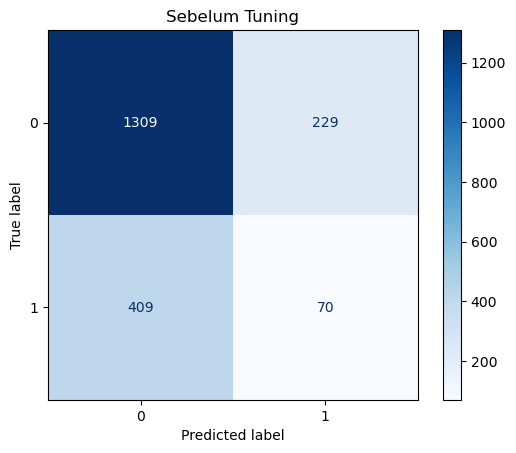

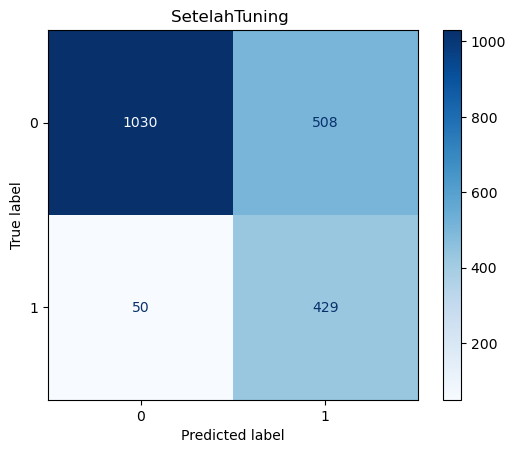

In [391]:
# Menampilkan confusion matrix sebelum tuning dengan warna biru muda
disp_before = ConfusionMatrixDisplay(confusion_matrix=cm_before)
disp_before.plot(cmap='Blues')  
plt.title('Sebelum Tuning')

# Menampilkan confusion matrix setelah tuning dengan warna hijau pastel
disp_after = ConfusionMatrixDisplay(confusion_matrix=cm_after)
disp_after.plot(cmap='Blues')  
plt.title('SetelahTuning ')

plt.show()

### **Analisis Perubahan Sebelum dan Setelah Tuning**

**Sebelum Tuning**

- `True Negatives (TN)` →  **1309**<br><br>
    Model berhasil mengidentifikasi 1309 pemesanan yang memang tidak dibatalkan. Angka ini menunjukkan bahwa model memiliki kemampuan awal yang cukup baik dalam mengenali data negatif atau pemesanan yang valid.<br><br>

- `False Positives (FP)` →  **229** <br><br>
    Sebanyak 229 pemesanan yang sebenarnya tidak dibatalkan salah diklasifikasikan oleh model sebagai pembatalan. Kesalahan ini dapat meningkatkan risiko overbooking, namun masih dalam batas yang relatif terkendali. <br><br>

-  `False Negatives (FN)` → **409** <br><br>
    Sebanyak 409 pembatalan tidak berhasil dideteksi oleh model, artinya pembatalan tersebut diprediksi sebagai pemesanan yang tidak dibatalkan. Tingginya nilai FN ini mencerminkan kelemahan model dalam mendeteksi pembatalan.<br><br>

-  `True Positives (TP)` → **70** <br><br>
    Hanya 70 pembatalan yang berhasil terdeteksi dengan benar oleh model. Angka ini menunjukkan bahwa performa awal recall model masih sangat rendah dalam mengenali data positif.<br><br>

**Setelah Tuning**

- `True Negatives (TN)` → **1030**<br><br>
    TN menurun menjadi 1030, artinya model menjadi kurang akurat dalam mengenali pemesanan yang tidak dibatalkan. Hal ini menunjukkan adanya kompromi dalam akurasi negatif demi meningkatkan recall.<br><br>

- `False Positives (FP)` → **508** <br><br>
    Jumlah FP meningkat signifikan menjadi 508, menunjukkan bahwa model semakin sering salah mengklasifikasikan pemesanan yang tidak dibatalkan sebagai pembatalan. Peningkatan ini adalah trade-off dari fokus yang lebih besar pada pengurangan FN.<br><br>

- `False Negatives (FN)` → **50**<br><br>
    FN mengalami penurunan drastis dari 409 menjadi 50, yang berarti model menjadi jauh lebih baik dalam mendeteksi pembatalan. Penurunan FN ini merupakan peningkatan signifikan pada kemampuan recall model.

- `True Positives (TP)` → **429**<br><br>
    TP meningkat secara signifikan dari 70 menjadi 429, menunjukkan bahwa model menjadi lebih efektif dalam mengidentifikasi pembatalan dengan benar. <br><br>  
    
**Kesimpulan**

Setelah proses tuning, model menunjukkan peningkatan yang signifikan dalam mendeteksi pembatalan, yang tercermin dari penurunan **False Negatives (FN)** dari **409 menjadi 50**. Artinya, model lebih mampu mengidentifikasi pembatalan secara akurat, sehingga mengurangi jumlah kasus pembatalan yang tidak terdeteksi. Selain itu, **True Positives (TP)** juga meningkat dari **70 menjadi 429**, yang mengindikasikan kemampuan model untuk secara konsisten mengenali pembatalan yang benar-benar terjadi.

Namun, terdapat peningkatan pada **False Positives (FP)** dari **229 menjadi 508**, menunjukkan adanya risiko overbooking yang lebih tinggi karena model lebih sering salah memprediksi pemesanan valid sebagai pembatalan. Di sisi lain, **True Negatives (TN)** turun dari **1309 menjadi 1030**, yang mencerminkan penurunan akurasi dalam mengenali pemesanan valid.

Meskipun terdapat peningkatan FP, penurunan FN yang signifikan tetap mendukung tujuan utama model, yaitu memastikan deteksi pembatalan yang lebih akurat untuk meminimalkan potensi kerugian. Dengan keseimbangan antara recall yang meningkat dan kontrol terhadap FP, model ini dapat membantu hotel untuk merencanakan operasional lebih baik dan mengoptimalkan pengelolaan reservasi."

## **6. Finalization**

-----

### **6.1. Selection**

- Berdasarkan tujuan **untuk meminimalkan** `False Negatives` **tanpa meningkatkan False Positives secara berlebihan**, `model dengan fitur baru (modeling 3, XGBoost dengan metode resampling RUS)` dipilih. <br><br>

- **Hal ini karena:**<br><br>
**1.  False Negatives jauh lebih rendah (50 vs 48)**, yang berarti model lebih baik dalam mendeteksi pembatalan.<br><br>
**2. False Positives tetap terkendali (508 vs 543)**, sehingga risiko overbooking masih dalam batas wajar.<br><br>
**3. F2 Score setelah tuning lebih tinggi (0.751) dibandingkan model pertama (0.74)**, menunjukkan performa keseluruhan yang lebih baik.<br><br>


> Dengan kemampuan recall yang lebih tinggi dan keseimbangan yang lebih baik antara False Negatives dan False Positives, modeling 3 dengan fitur tambahan memberikan solusi optimal untuk memenuhi tujuan utama model prediksi.

### **6.2. Feature Importances**

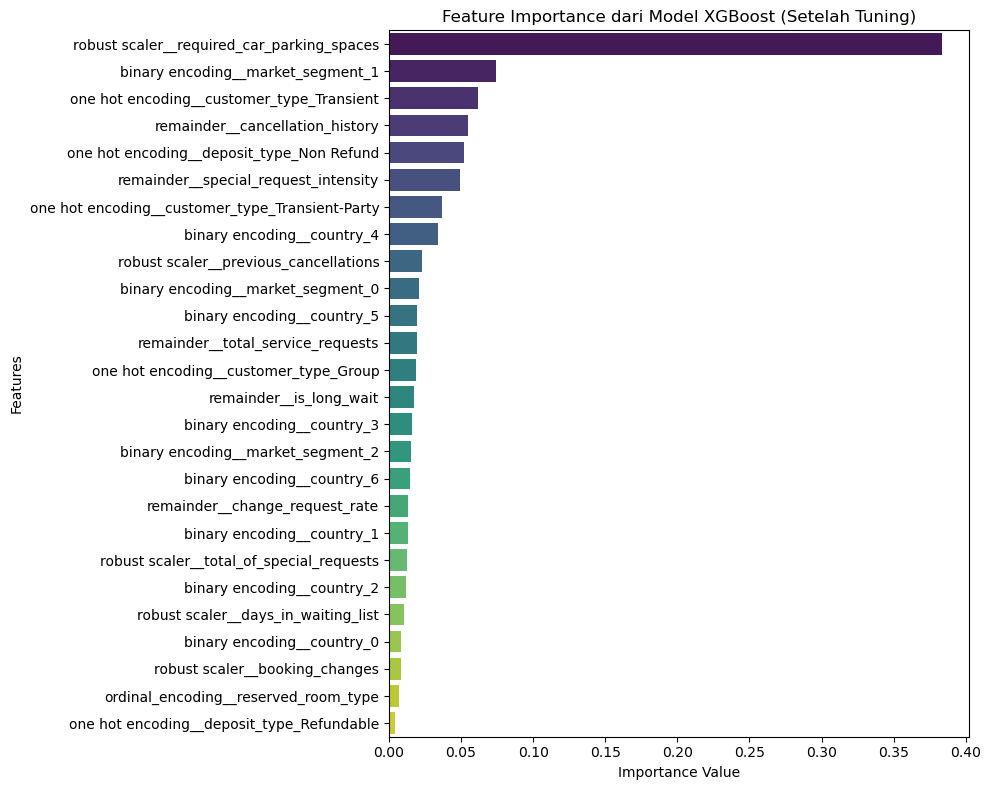

In [393]:
# Mengekstrak nilai pentingnya fitur dari model terbaik
feature_imp = pd.DataFrame(
    model_after.named_steps['model'].feature_importances_,  # Akses langkah model dari pipeline
    index=model_after.named_steps['preprocessing'].get_feature_names_out(),  # Akses nama fitur dari preprocessing
    columns=['Value']
).sort_values(by='Value', ascending=False)

# Membuat visualisasi dengan barplot
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_imp, x='Value', y=feature_imp.index, palette='viridis')
plt.title('Feature Importance )')
plt.xlabel('Importance Value')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


In [394]:
# Mendapatkan nama-nama fitur dari langkah preprocessing dalam pipeline
model_after[0].get_feature_names_out()

array(['one hot encoding__deposit_type_Non Refund',
       'one hot encoding__deposit_type_Refundable',
       'one hot encoding__customer_type_Group',
       'one hot encoding__customer_type_Transient',
       'one hot encoding__customer_type_Transient-Party',
       'binary encoding__country_0', 'binary encoding__country_1',
       'binary encoding__country_2', 'binary encoding__country_3',
       'binary encoding__country_4', 'binary encoding__country_5',
       'binary encoding__country_6', 'binary encoding__market_segment_0',
       'binary encoding__market_segment_1',
       'binary encoding__market_segment_2',
       'ordinal_encoding__reserved_room_type',
       'robust scaler__previous_cancellations',
       'robust scaler__booking_changes',
       'robust scaler__days_in_waiting_list',
       'robust scaler__required_car_parking_spaces',
       'robust scaler__total_of_special_requests',
       'remainder__total_service_requests',
       'remainder__cancellation_history',
   

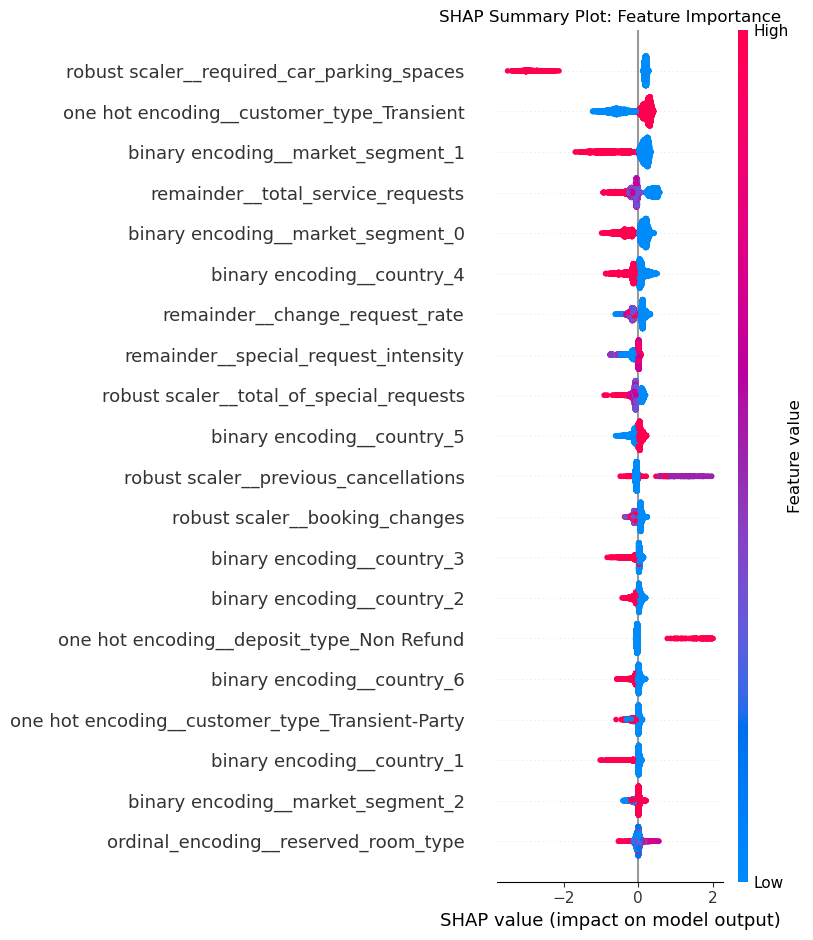

In [395]:


#  Mengakses model XGBoost dari pipeline
xgb_model = model_after.named_steps['model']  # Akses langkah model dari pipeline

#  Memproses data latih menggunakan preprocessing dari pipeline
X_train_processed = pd.DataFrame(
    model_after.named_steps['preprocessing'].transform(X_train),  # Transformasi data latih
    columns=model_after.named_steps['preprocessing'].get_feature_names_out()  # Mendapatkan nama fitur
)

# Membuat SHAP explainer untuk interpretasi model
explainer = shap.TreeExplainer(xgb_model)  # Membuat explainer berdasarkan model XGBoost

# Mendapatkan nilai SHAP untuk setiap fitur dalam data
shap_values = explainer.shap_values(X_train_processed)  # Hitung nilai SHAP berdasarkan data yang telah diproses

# Visualisasi SHAP Summary Plot
plt.title("SHAP Summary Plot: Feature Importance")
shap.summary_plot(shap_values, X_train_processed, feature_names=X_train_processed.columns)


#### **Analisis Nilai SHAP untuk Model Prediksi Pembatalan Booking Hotel**

>**Gambaran Umum Plot SHAP**<br><br>

Plot ini menggambarkan pengaruh setiap fitur terhadap prediksi model. **Setiap baris merepresentasikan satu fitur**, sedangkan **titik-titik menunjukkan kontribusi fitur terhadap prediksi individu**. **Sumbu x** menunjukkan **nilai SHAP** (seberapa besar dampak fitur terhadap output model), dan **warna** menggambarkan **nilai fitur** (biru untuk nilai rendah, merah untuk nilai tinggi).<br><br>

---

>**Analisis Fitur Utama**<br><br>

1. **`robust_scaler__required_car_parking_spaces`**  
    - **Encoding**<br> Fitur ini dihasilkan melalui robust scaling untuk jumlah kebutuhan tempat parkir mobil.<br><br>
    - **Dampak**<br> Memberikan kontribusi positif yang signifikan terhadap prediksi pembatalan, terutama untuk nilai tinggi.<br><br>
    - **Interpretasi**<br>
        - Semakin tinggi kebutuhan tempat parkir, semakin besar dampaknya dalam meningkatkan kemungkinan pembatalan.
        - Hal ini mungkin mencerminkan karakteristik tamu yang lebih memilih untuk membatalkan di lokasi tertentu atau dengan properti tertentu.<br><br>

2. **`one hot encoding__customer_type_Transient`**  
    - **Encoding**<br> Fitur kategori yang di-encode menggunakan one-hot encoding untuk jenis pelanggan 'Transient'.<br><br>
    - **Dampak**<br> Memiliki pengaruh yang signifikan terhadap prediksi, baik untuk nilai tinggi maupun rendah.<br><br>
    - **Interpretasi**<br>
        - Pelanggan tipe 'Transient' cenderung lebih sering terlibat dalam pembatalan, dibandingkan tipe pelanggan lainnya.
        - Perubahan warna dari biru ke merah menunjukkan adanya variasi besar dalam pola perilaku pelanggan transient.<br><br>

3. **`remainder__total_service_requests`**  
    - **Encoding**<br> Fitur tambahan yang dihasilkan berdasarkan total permintaan layanan, dibiarkan langsung (passthrough) ke model.<br><br>
    - **Dampak**<br> Memberikan kontribusi positif terhadap prediksi pembatalan.<br><br>
    - **Interpretasi**<br>
        - Jumlah permintaan layanan yang lebih tinggi dapat meningkatkan kemungkinan pembatalan, mencerminkan kompleksitas atau ketergantungan pada layanan tambahan.<br><br>

4. **`binary_encoding__market_segment_1`**  
    - **Encoding**<br> Fitur hasil binary encoding untuk segmen pasar.<br><br>
    - **Dampak**<br> Meskipun tidak signifikan, fitur ini tetap memberikan kontribusi terhadap prediksi model.<br><br>
    - **Interpretasi**<br>
        - Segmen pasar tertentu memiliki sedikit pengaruh, tetapi masih dapat memberikan informasi tambahan untuk segmentasi pelanggan.<br><br>

---

**Kesimpulan Analisis**

- **Pentingnya Fitur**<br>
  Fitur seperti `required_car_parking_spaces`, `customer_type_Transient`, dan `total_service_requests` memiliki pengaruh yang lebih besar dibandingkan fitur seperti segmen pasar. Hal ini menunjukkan bahwa model lebih menekankan pada faktor operasional dan pola permintaan daripada kategori segmen pasar.<br><br>

- **Pengolahan Data**<br>
  - **Robust scaling** diterapkan untuk menangani outlier pada fitur kontinu seperti jumlah kebutuhan tempat parkir.  
  - **One-hot encoding** digunakan untuk variabel kategori dengan sedikit kategori, seperti tipe pelanggan.  
  - **Passthrough** diterapkan untuk fitur biner tambahan seperti total permintaan layanan.<br><br>

- **Fokus Model**<br>
  Model ini lebih memprioritaskan pola perilaku pelanggan dan kebutuhan layanan, yang mencerminkan dampak langsung terhadap operasi hotel dan keputusan pembatalan.

### **6.3. Loss Analysis**

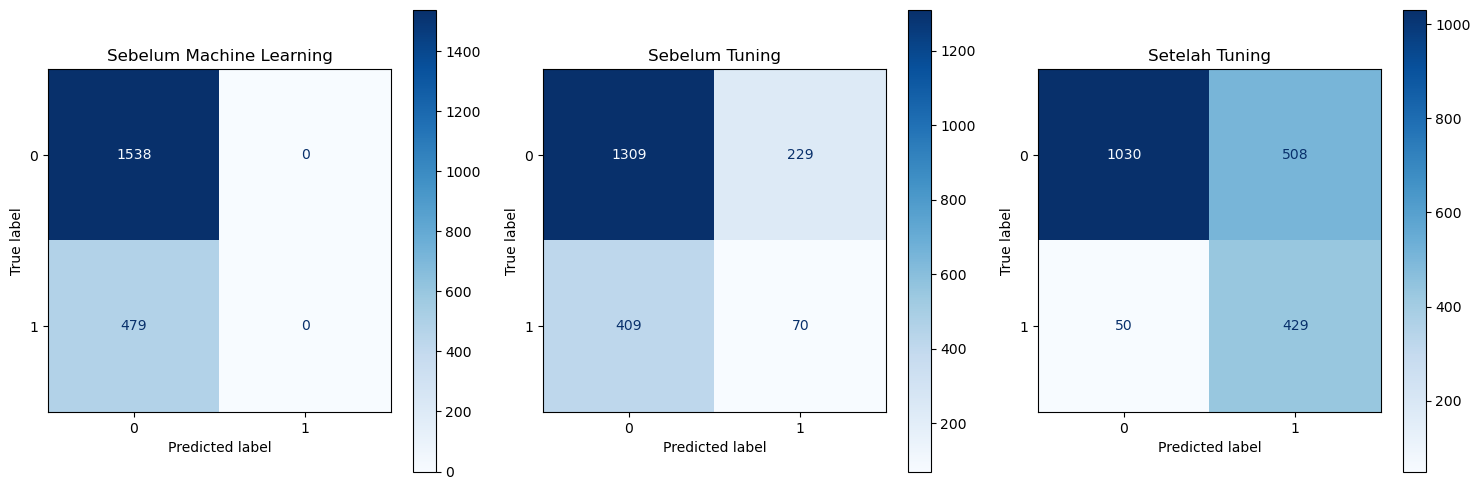

In [425]:
# Jumlah sampel pada data uji
n_samples = len(y_test)

# Prediksi untuk skenario "Before Machine Learning" (semua diprediksi 0)
y_pred_before_ml = np.zeros(n_samples, dtype=int)  

# Membuat confusion matrix untuk setiap skenario
cm_dict = {
    'Sebelum Machine Learning': confusion_matrix(y_test, y_pred_before_ml),  
    'Sebelum Tuning': confusion_matrix(y_test, y_pred_before), 
    'Setelah Tuning': confusion_matrix(y_test, y_pred_after)  
}

# Membuat subplot untuk visualisasi semua confusion matrix
n_matrices = len(cm_dict)
fig, axes = plt.subplots(1, n_matrices, figsize=(15, 5))  # Ukuran figure dapat disesuaikan

# Memastikan axes selalu iterabel
axes = [axes] if n_matrices == 1 else axes

# Plot setiap confusion matrix
for (judul, cm), ax in zip(cm_dict.items(), axes):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, values_format='d', cmap='Blues')  
    ax.set_title(judul)

# Menyesuaikan tata letak untuk tampilan lebih baik
plt.tight_layout()
plt.show()




#### **Analisis Kerugian**

1. **Before Machine Learning**
   - **False Positive (FP) Loss**: $30 × 0 = $0
   - **False Negative (FN) Loss**: $100 × 479 = $47,900
   - **Total Loss = $47,900**

2. **Before Tuning**
   - **False Positive (FP) Loss**: $30 × 229 = $6,870
   - **False Negative (FN) Loss**: $100 × 409 = $40,900
   - **Total Loss = $6,870 + $40,900 = $47,770**

3. **After Tuning**
   - **False Positive (FP) Loss**: $30 × 508 = $15,240
   - **False Negative (FN) Loss**: $100 × 50 = $5,000
   - **Total Loss = $15,240 + $5,000 = $20,240**

---
<br>

#### **Ringkasan Kerugian**

|  **Confusion Matrix**          | **FP Loss ($)** | **FN Loss ($)** | **Total Loss ($)** |
|-------------------------------|-----------------|-----------------|--------------------|
| **Before Machine Learning**   | 0               | 47,900          | 47,900            |
| **Before Tuning**             | 6,870           | 40,900          | 47,770            |
| **After Tuning**              | 15,240          | 5,000           | 20,240            |


<br><br>

---

#### **Analisis Kerugian Bisnis**
- **Before Machine Learning** menghasilkan kerugian terbesar sebesar $47,900, yang sepenuhnya disebabkan oleh tingginya jumlah False Negatives (FN). Hal ini menunjukkan banyaknya pembatalan yang tidak terdeteksi.
  
- **Before Tuning** berhasil mengurangi kerugian menjadi $47,770, dengan penurunan FN Loss, meskipun FP Loss mulai muncul.

- **After Tuning** menghasilkan kerugian terendah sebesar $20,240. Walaupun FP Loss meningkat, pengurangan signifikan pada FN Loss menjadi faktor utama dalam menurunkan total kerugian.<br><br>

>Model yang telah dituning mampu mengurangi kerugian sebesar **$27,660** dibandingkan dengan skenario awal tanpa machine learning. Ini menunjukkan efektivitas model dalam mengurangi pembatalan yang tidak terdeteksi, sehingga membantu optimalisasi pendapatan.


## **7. Conclusion and Recommendations**

-----

### **7.1 Conclusion** <br>
Berdasarkan analisis data dan pemodelan yang dilakukan, berikut adalah kesimpulan utama dari proyek ini : <br>

- **Pemilihan Model**<br>
Model terbaik adalah `XGBoost dengan fitur tambahan (Model 3)`, yang menunjukkan kinerja lebih baik dibandingkan model lain seperti Decision Tree, KNN, Random Forest, AdaBoost, Gradient Boost, dan Logistic Regression, setelah dilakukan validasi silang.<br><br>

- **Kinerja Model** <br>Setelah dilakukan tuning hyperparameter, model `XGBoost` mencapai F2 Score sebesar **0.751**, meningkat signifikan dibandingkan skor sebelum tuning sebesar 0.416.<br><br>

- **Analisis Kerugian Bisnis** <br>Hasil analisis kerugian menunjukkan perubahan positif:
  - **Before Machine Learning** <br>Kerugian total mencapai **$47,900** akibat tingginya False Negatives (FN)<br><br>
  - **Before Tuning** <br>Kerugian total menurun menjadi **$47,770**, dengan kombinasi False Positives (FP) dan FN yang lebih seimbang.<br><br>
  - **After Tuning** <br>Kerugian total menurun signifikan menjadi **$20,240**, dengan penurunan FN sebagai faktor utama meskipun FP meningkat.<br><br>

- **Pentingnya Fitur**<br> Berdasarkan analisis SHAP, fitur berikut memiliki dampak signifikan terhadap prediksi model:<br>
  - `required_car_parking_spaces` <br>Korelasi positif kuat dengan prediksi pembatalan, menunjukkan bahwa semakin banyak tempat parkir yang diminta, semakin tinggi kemungkinan pembatalan.<br><br>
  - `previous_cancellations` <br>Pembatalan sebelumnya memiliki dampak positif yang signifikan pada prediksi, menandakan hubungan prediktif yang kuat.<br><br>
  - `market_segment` <br>Memberikan kontribusi minimal terhadap prediksi, sehingga dapat menjadi area eksplorasi lebih lanjut atau refinemen fitur.<br><br>

---

### **7.2 Recommendations** <br>

#### **7.2.1 Recommendations for the company** 

**1. Implementasi Model Prediksi**<br>

Integrasi model prediksi `XGBoost dengan fitur tambahan (Model 3)` ke dalam sistem reservasi hotel dapat menjadi solusi untuk meminimalkan kerugian akibat pembatalan. Model ini telah terbukti efektif mengurangi kerugian total dari **$47,900** sebelum menggunakan model menjadi **$20,240** setelah tuning. Dengan kemampuannya memprediksi kemungkinan pembatalan lebih awal, hotel dapat segera mengambil langkah strategis, seperti menjual kembali kamar yang berisiko kosong atau menawarkan insentif dan memberikan penawaran khusus kepada tamu untuk memastikan kedatangan mereka. Hal ini memberikan hotel peluang untuk mengoptimalkan pendapatan sekaligus meningkatkan efisiensi operasional.<br><br><br>
**2. Fokus Mengurangi False Negatives (FN)**

False Negatives memiliki dampak terbesar terhadap kerugian karena menyebabkan kamar kosong yang tidak dapat dijual kembali. Salah satu strategi yang dapat diterapkan adalah **sistem notifikasi konfirmasi otomatis**, yang mengirim pengingat kepada tamu beberapa hari sebelum check-in. Notifikasi ini dapat mendorong tamu untuk mengonfirmasi reservasi mereka. Jika tamu tidak memberikan konfirmasi, reservasi tersebut dapat ditandai sebagai berisiko batal, sehingga hotel memiliki waktu untuk menjual kamar tersebut kepada tamu lain. Selain itu, memberikan insentif, seperti diskon bagi tamu yang mengonfirmasi lebih awal, juga dapat membantu mengurangi risiko pembatalan mendadak.<br><br><br>
**3. Strategi Harga dan Pembayaran Berdasarkan Fitur Penting**

Dari analisis fitur, diketahui bahwa `kebutuhan tempat parkir` dan `riwayat pembatalan sebelumnya` adalah faktor penting yang memengaruhi pembatalan. Oleh karena itu, hotel dapat menggunakan informasi ini untuk menetapkan strategi harga dinamis. Sebagai contoh, tamu yang membutuhkan lebih banyak tempat parkir dapat diberikan harga lebih tinggi karena mereka cenderung lebih stabil dalam melakukan reservasi. Sebaliknya, tamu dengan riwayat pembatalan tinggi dapat dikenakan kebijakan pembayaran di muka atau deposit non-refundable untuk mengurangi risiko pembatalan mendadak.<br><br><br>
**4. Segmentasi Pelanggan**

Strategi segmentasi pelanggan dapat membantu hotel memfokuskan promosi pada segmen tamu yang lebih stabil, seperti grup perusahaan atau keluarga besar. Sementara itu, untuk pelanggan dengan riwayat pembatalan tinggi, hotel dapat meningkatkan komunikasi melalui pengingat jadwal secara berkala atau menerapkan kebijakan reservasi yang lebih tegas. Dengan pendekatan ini, hotel dapat mengoptimalkan strategi pemasarannya sekaligus mengurangi risiko kerugian akibat pembatalan.




#### **7.2.2. Recommendations for future model development** 

**1. Eksplorasi Model Alternatif**  <br><br>
Walaupun XGBoost telah menunjukkan performa yang unggul, mencoba model lain seperti `LightGBM`, `CatBoost`, atau bahkan pendekatan ensemble seperti stacking bisa menjadi peluang untuk meningkatkan akurasi. <br><br><br>

**2. Optimalisasi Hyperparameter yang Lebih Lanjut**<br><br>
Hyperparameter tuning yang telah dilakukan sebelumnya berhasil meningkatkan F2 Score secara signifikan, yang menunjukkan peningkatan kemampuan model dalam menyeimbangkan False Negatives (FN) dan False Positives (FP). Namun, untuk mencapai keseimbangan yang lebih optimal, pendekatan seperti `GridSearchCV` dapat diterapkan. Dengan menjelajahi kombinasi parameter yang lebih luas, metode ini dapat membantu model menangkap pola data yang lebih kompleks, sehingga mampu meminimalkan FN tanpa secara drastis meningkatkan FP.<br><br><br>

**3. Penambahan Fitur Baru**  <br><br>
Mempertimbangkan fitur baru yang relevan seperti data eksternal (misalnya cuaca, event lokal, atau data ekonomi) dapat meningkatkan akurasi model. Fitur tambahan ini dapat memberikan konteks yang lebih kaya pada prediksi, seperti pola pembatalan musiman atau dampak dari acara tertentu di wilayah sekitar hotel.<br><br><br>


**4. Peningkatan Klasifikasi False Positives (FP)**<br><br>Fokus pada pengurangan jumlah False Positives, karena jumlah yang tinggi dapat memengaruhi efisiensi operasional secara keseluruhan, meskipun kerugian akibat FP lebih kecil.